In [ ]:
!pip install pulseqzero
!pip install MRzeroCore &> /dev/null
!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/numerical_brain_cropped.mat &> /dev/null

!pip install numpy==1.24

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 104.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchkbnufft 1.5.2 requires numpy>=2.0.0, but you have numpy 1.24.0 which is incompatible.
chex 0.1.88 requires numpy>=1.24.1, but you have numpy 1.24.0 which is incompatible.
albucore 0.0.19 requires numpy>=1.24.4, but you have numpy 1.24.0 which is incompatible.
albumentations 1.4.20 requires numpy>=1.24.4, but you have numpy 1.24.0 which is incompatible.
pymc 5.19.1 requires numpy>=1.25.0, but you have numpy 1.24.0 which is incompatible.
blosc2 3.0.0 requires numpy>=1.25.0, but you have numpy 1.24.0 which is incompatible.
imbalanced-learn 0.13.0 requires numpy<3,>=1.24.3, but you have nu

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib import cm

import MRzeroCore as mr0
import pulseqzero
pp = pulseqzero.pp_impl

/usr/local/lib/python3.11/dist-packages/sigpy/config.py:27: UserWarning: Importing cupy.cuda.cudnn failed. For more details, see the error stack below:
libcudnn.so.8: cannot open shared object file: No such file or directory
  warnings.warn(


(TSE_FAopt_SAR)=
# Pulseq-zero Demo
Pulseq-zero combines Pusleq and MR-zero and allows you to optimize a Pulseq sequence dirrectly.

For example, herein we want to optimize the variable refocusing flip angle train of a TSE sequence to achieve low SAR.



###First,###
we now need to define a TSE sequence as function with parameters we wish to optimize as arguments:

In [ ]:
#@title Define TSE in PyPulseq
def tse_sequence(fov=200e-3, slice_thickness=8e-3, base_resolution=42,
                 TE_ms=5, TI_s=0, Ex_FA=90, Ref_FA=180, r_spoil=2,
                 PE_grad_on=True, RO_grad_on=True):
    """
    Generates a TSE sequence using PyPulseq.

    Args:
        system: PyPulseq system object.
        fov (float): Field of view in meters (default: 200e-3).
        slice_thickness (float): Slice thickness in meters (default: 8e-3).
        base_resolution (int): Base resolution for frequency and phase encoding (default: 42).
        TE_ms (float): Echo time in milliseconds (default: 5).
        TI_s (float): Inversion time in seconds (default: 0).
        Ex_FA (float): Excitation flip angle in degrees (default: 90).
        Ref_FA (float or array): Refocusing flip angle in degrees (default: 180).
        r_spoil (float): Spoil gradient factor (default: 2).
        PE_grad_on (bool): Enable/disable phase encoding gradients (default: True).
        RO_grad_on (bool): Enable/disable readout gradients (default: True).

    Returns:
        PyPulseq sequence object.
    """
    # Define resolution
    Nread = base_resolution  # frequency encoding steps/samples
    Nphase = base_resolution  # phase encoding steps/samples
    TE = TE_ms * 1e-3

    # %% S1. SETUP sys
    system = pp.Opts(
        max_grad=28, grad_unit='mT/m', max_slew=150, slew_unit='T/m/s',
        rf_ringdown_time=20e-6, rf_dead_time=100e-6,
        adc_dead_time=20e-6, grad_raster_time=10e-6)

    seq = pp.Sequence(system)

    # Define rf events
    rf1, gz1, gzr1 = pp.make_sinc_pulse(
        flip_angle=Ex_FA * np.pi / 180, phase_offset=90 * np.pi / 180, duration=1e-3,
        slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
        system=system, return_gz=True)

    rf2, gz2, _ = pp.make_sinc_pulse(
        flip_angle=180*np.pi / 180, duration=1e-3,
        slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
        system=system, return_gz=True)

    dwell=50e-6*2

    G_flag=(int(RO_grad_on),int(PE_grad_on))  # gradient flag (read,PE), if (0,0) all gradients are 0, for (1,0) PE is off

    # Define other gradients and ADC events
    gx = pp.make_trapezoid(channel='x', rise_time = 0.5*dwell, flat_area=Nread / fov*G_flag[0], flat_time=Nread*dwell, system=system)
    adc = pp.make_adc(num_samples=Nread, duration=Nread*dwell, phase_offset=90 * np.pi / 180, delay=0*gx.rise_time, system=system)
    gx_pre0 = pp.make_trapezoid(channel='x', area=+((1.0 + r_spoil) * gx.area / 2) , duration=1.5e-3, system=system)
    gx_prewinder = pp.make_trapezoid(channel='x', area=+(r_spoil * gx.area / 2), duration=1e-3, system=system)
    gp = pp.make_trapezoid(channel='y', area=0 / fov, duration=1e-3, system=system)
    rf_prep = pp.make_block_pulse(flip_angle=180 * np.pi / 180, duration=1e-3, system=system)


    # FLAIR
    if TI_s>0:
      seq.add_block(rf_prep)
      seq.add_block(pp.make_delay(TI_s))
      seq.add_block(gx_pre0)

    seq.add_block(rf1,gz1)
    seq.add_block(gx_pre0,gzr1)

    # the minimal TE is given by one full period form ref pulse to ref pulse, thus gz2+gx+2*gp
    minTE2=(pp.calc_duration(gz2) +pp.calc_duration(gx) + 2*pp.calc_duration(gp))/2

    minTE2=np.round(minTE2/10e-5)*10e-5


    # to realize longer TE,  we introduce a TEdelay that is added before and afetr the encoding period
    TEd=np.round(max(0, (TE/2-minTE2))/10e-5)*10e-5  # round to raster time

    if TEd==0:
      print('echo time set to minTE [ms]', 2*(minTE2 +TEd)*1000)
    else:
      print(' TE [ms]', 2*(minTE2 +TEd)*1000)


    # last timing step is to add TE/2 also between excitation and first ref pulse
    # from pulse top to pulse top we have already played out one full rf and gx_pre0, thus we substract these from TE/2
    seq.add_block(pp.make_delay((minTE2 +TEd ) - pp.calc_duration(gz1)-pp.calc_duration(gx_pre0)))

    encoding = []

    for ii in range(-Nphase // 2, Nphase // 2):  # e.g. -64:63
        gp  = pp.make_trapezoid(channel='y', area=+ii / fov*G_flag[1], duration=1e-3, system=system)
        gp_ = pp.make_trapezoid(channel='y', area=-ii / fov*G_flag[1], duration=1e-3, system=system)
        encoding.append(ii)

        # Try to index into a variable FA array, if it fails treat it as number
        try:
            flip_angle = Ref_FA[ii] * torch.pi / 180
        except:
            flip_angle = Ref_FA * torch.pi / 180
        rf2, gz2, _ = pp.make_sinc_pulse(flip_angle=flip_angle, duration=1e-3,slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,system=system, return_gz=True)

        seq.add_block(rf2,gz2)
        seq.add_block(pp.make_delay(TEd)) # TE delay
        seq.add_block(gx_prewinder, gp)
        seq.add_block(adc, gx)
        seq.add_block(gx_prewinder, gp_)
        seq.add_block(pp.make_delay(TEd)) # TE delay

    # %% S2. CHECK, PLOT and WRITE the sequence  as .seq
    # Check whether the timing of the sequence is correct
    ok, error_report = seq.check_timing()
    if ok:
        print('Timing check passed successfully')
    else:
        print('Timing check failed. Error listing follows:')
        [print(e) for e in error_report]

    return seq, encoding

In [ ]:
# @title image reconstruction via FFT

def reconstruction(signal, encoding, Nread, Nphase):
  # reconstruct image
  kspace = torch.reshape((signal), (Nread, Nphase)).clone().t()
  encoding = np.stack(encoding)
  ipermvec = np.argsort(encoding)
  kspace=kspace[:,ipermvec]

  # fftshift FFT fftshift
  spectrum = torch.fft.fftshift(kspace)
  space = torch.fft.fft2(spectrum)
  space = torch.fft.ifftshift(space)

  return space

In [ ]:
# @title ploting functions for optimization steps and results

def plot_results_images(target, result, finished=False, colorbars=False):

  # show target, initial and optimized image on common colorscale
  vmin = min(target.min(), result.min())
  vmax = max(target.max(), result.max())

  plt.subplot(121)
  plt.title("optimizer target")
  plt.axis('off')
  mr0.util.imshow(target, vmin=vmin, vmax=vmax, cmap=cm.gray)
  if colorbars: plt.colorbar(cmap='gray')

  plt.subplot(122)
  if finished: plt.title("optimizer result")
  else: plt.title("optimizer step")
  plt.axis('off')
  mr0.util.imshow(result, vmin=vmin, vmax=vmax, cmap=cm.gray)
  if colorbars: plt.colorbar(cmap='gray')

  plt.show()

def plot_optimizer_history(loss_hist, param_hist, rSNR_hist, finished=False):
    #plt.figure(figsize=(12, 4))

    plt.subplot(121)
    plt.title("Loss and rSNR")
    plt.xlabel("itertation")
    plt.plot([l / loss_hist[0] for l in loss_hist], label="loss")
    plt.plot(rSNR_hist, label="rSNR")
    if finished:
      plt.plot([np.argmin(loss_hist), np.argmin(loss_hist)], [[l / loss_hist[0] for l in loss_hist][np.argmin(loss_hist)], rSNR_hist[np.argmin(loss_hist)]], "rx", label="optimum")

    plt.legend()
    plt.grid()

    plt.subplot(122)
    plt.xlabel("repetition")
    plt.ylabel("FA")
    plt.title("Optim. param")
    if finished: plt.plot(np.array(param_hist).T)
    else: plt.plot(np.array(param_hist[-2:]).T) # only plot current and last flip angle configuration
    plt.gca().yaxis.tick_right()
    plt.grid()

    plt.show()

def plot_optimized_flipangles(fa_optimized):
  plt.plot(fa_optimized, "o--")
  plt.xlabel("repetition")
  plt.ylabel("FA [deg]")
  plt.title("Optimized refocusing flip angles")
  plt.gca().yaxis.tick_right()
  plt.grid()
  plt.show()

In [ ]:
# @title Setup spin system

obj_p = mr0.util.load_phantom([96,96])


echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully


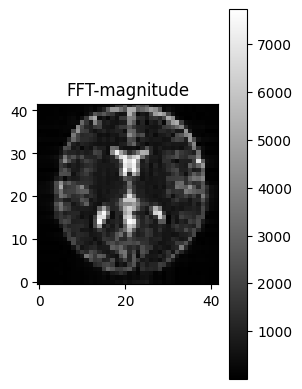

In [ ]:
# @title Generate optimization target

base_resolution=42
Ex_FA=90    # excitation flip angle
Ref_FA_target= torch.full((base_resolution,), 180)  # refocusing flip angle

with pulseqzero.mr0_mode():
  seq, encoding = tse_sequence(base_resolution=base_resolution, Ex_FA=Ex_FA, Ref_FA=Ref_FA_target)

  seq0 = seq.to_mr0()
  signal,_ = mr0.util.simulate(seq0,obj_p,accuracy=1e-4)

# reconstruct image
space = reconstruction(signal, encoding, base_resolution, base_resolution)

# plot result
plt.subplot(121)
plt.title('FFT-magnitude')
mr0.util.imshow(np.abs(space.numpy()), cmap=cm.gray)
plt.colorbar()

# store target for optimization
target = torch.abs(space)

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
1 / 100: loss=0.15000000596046448, rSAR=1.0, Ref_FA=[180. 180. 180. 180. 180. 180. 180. 180. 180. 180. 180. 180. 180. 180.
 180. 180. 180. 180. 180. 180. 180. 180. 180. 180. 180. 180. 180. 180.
 180. 180. 180. 180. 180. 180. 180. 180. 180. 180. 180. 180. 180. 180.]


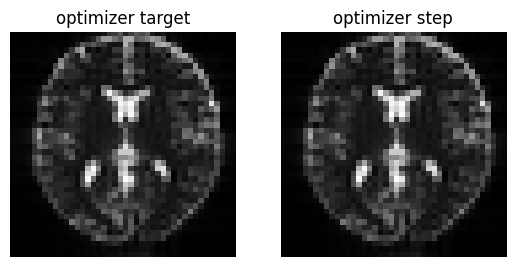

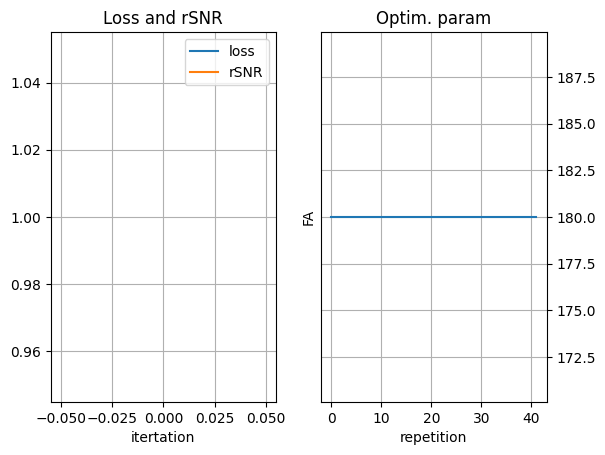

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
2 / 100: loss=0.14181561768054962, rSAR=0.9452298283576965, Ref_FA=[175.00127 175.00127 175.00127 175.00127 175.00127 175.00127 175.00127
 175.00127 175.00127 175.00127 175.00127 175.00127 175.00127 175.00127
 175.00127 175.00127 175.00127 175.00127 175.00127 175.00127 175.00127
 175.00127 175.00127 175.00127 175.00127 175.00127 175.00127 175.00127
 175.00127 175.00127 175.00127 175.00127 175.00127 175.00127 175.00127
 175.00127 175.00127 175.00127 175.00127 175.00127 175.00127 175.00127]


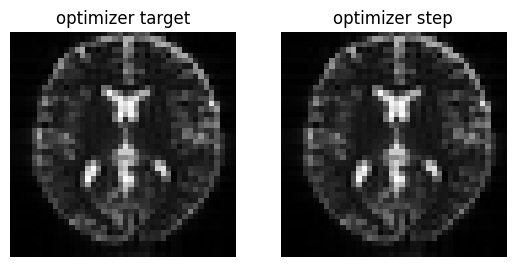

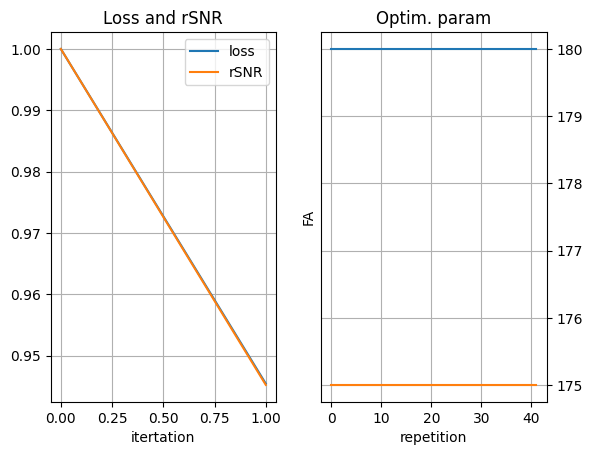

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
3 / 100: loss=0.13390499353408813, rSAR=0.8920814990997314, Ref_FA=[170.0205  170.00363 170.00792 170.00731 170.00742 170.00784 170.00731
 170.00687 170.00691 170.00693 170.00691 170.00691 170.00668 170.007
 170.00658 170.00702 170.00668 170.00685 170.00674 170.00676 170.00676
 170.03532 169.99783 170.02077 170.00296 170.00954 170.01053 170.0032
 170.01826 169.9999  170.02501 169.9982  170.03012 169.99738 170.03291
 169.99706 170.03358 169.9971  170.03271 169.99745 170.02985 169.99767]


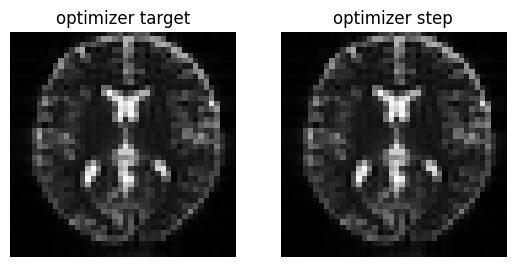

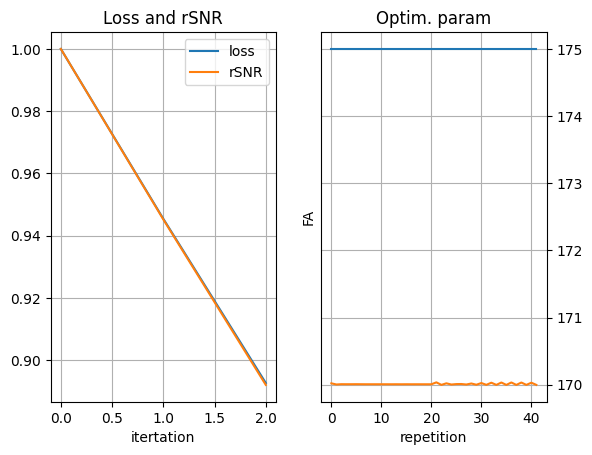

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
4 / 100: loss=0.12627844512462616, rSAR=0.8405940532684326, Ref_FA=[165.04234 165.0195  165.01907 165.02652 165.01974 165.02292 165.01897
 165.02066 165.01976 165.01993 165.01988 165.01984 165.01944 165.02
 165.01907 165.02008 165.01944 165.01962 165.0195  165.01938 165.01942
 165.1915  164.98222 165.11412 164.99335 165.0505  165.01688 165.01582
 165.04568 164.99904 165.07193 164.9914  165.08965 164.98889 165.0937
 164.99031 165.08571 164.9941  165.07445 165.00185 165.06294 165.00475]


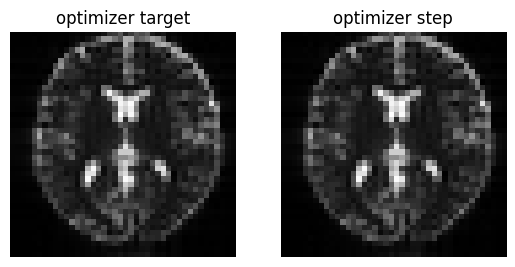

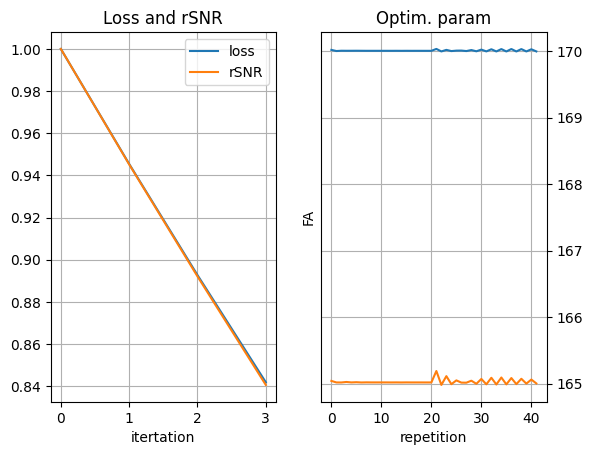

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
5 / 100: loss=0.1189442053437233, rSAR=0.7908889055252075, Ref_FA=[160.04874 160.07237 160.03221 160.07404 160.0365  160.0511  160.03967
 160.04529 160.04425 160.0425  160.04507 160.04155 160.04465 160.04193
 160.0435  160.0425  160.04343 160.0426  160.04259 160.04239 160.04228
 160.68083 159.95274 160.38182 159.96725 160.14542 160.02402 160.03264
 160.11012 159.98744 160.18866 159.97139 160.22322 159.9701  160.20256
 159.98456 160.14755 160.01279 160.1025  160.0527  160.08168 160.07326]


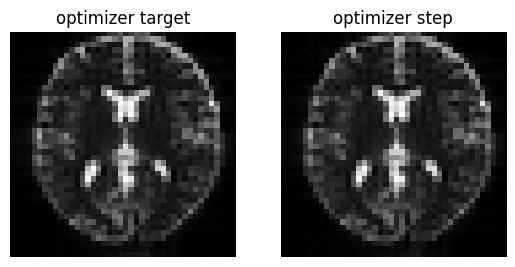

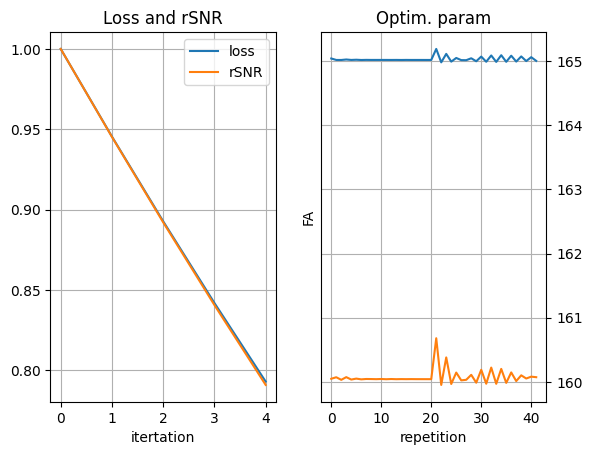

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
6 / 100: loss=0.11175167560577393, rSAR=0.7431010007858276, Ref_FA=[155.0288  155.15508 155.06467 155.13698 155.06526 155.09396 155.07559
 155.0809  155.08626 155.07607 155.087   155.07428 155.08624 155.0759
 155.0829  155.0783  155.08127 155.07973 155.07869 155.07936 155.07841
 156.62393 154.9022  155.82877 154.93256 155.25406 155.07971 155.02473
 155.3228  154.95018 155.5237  154.92789 155.54759 154.93105 155.40794
 154.97627 155.2203  155.07402 155.10774 155.20082 155.07239 155.30455]


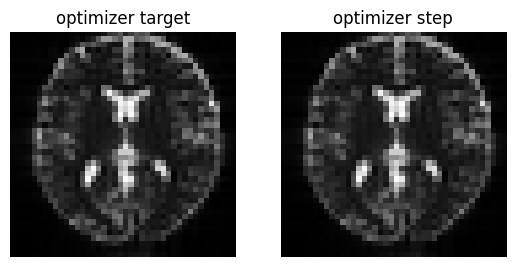

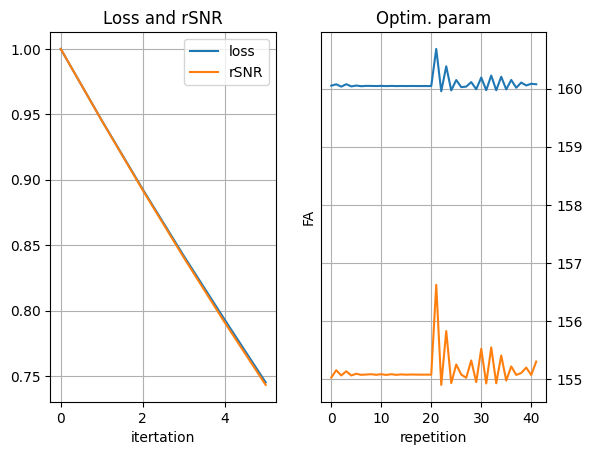

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
7 / 100: loss=0.10500513017177582, rSAR=0.6969452500343323, Ref_FA=[149.98244 150.24777 150.10823 150.22118 150.10446 150.16649 150.11853
 150.14754 150.13718 150.13486 150.14261 150.1263  150.1458  150.12549
 150.14182 150.12915 150.13834 150.13286 150.1325  150.13278 150.13165
 152.4017  149.9406  151.15657 150.01279 150.32402 150.20567 150.03943
 150.51933 149.98143 150.77882 149.97343 150.78864 149.97116 150.57104
 150.03091 150.28183 150.20392 150.10085 150.45511 150.03798 150.68613]


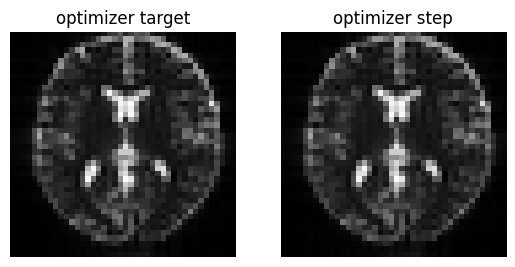

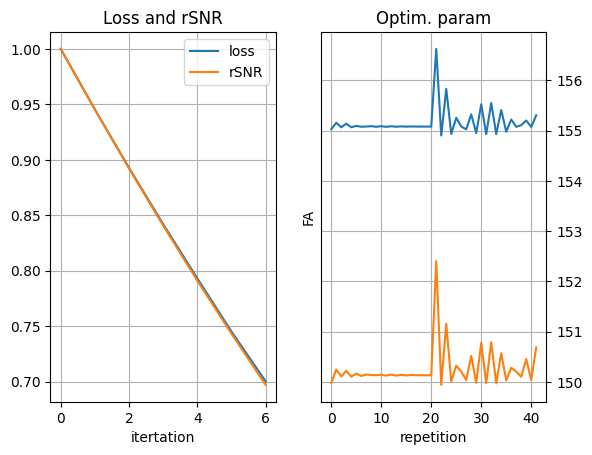

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
8 / 100: loss=0.0986156091094017, rSAR=0.6525260210037231, Ref_FA=[144.90518 145.3545  145.16629 145.34093 145.15292 145.28273 145.16647
 145.25743 145.19818 145.22427 145.21622 145.19998 145.22943 145.19292
 145.22498 145.1988  145.21771 145.20659 145.20662 145.20691 145.20522
 148.17572 145.03012 146.4262  145.19644 145.37463 145.40417 145.08835
 145.71107 145.08888 145.98334 145.09933 145.99222 145.06639 145.74564
 145.12453 145.36815 145.39261 145.09286 145.85052 144.97949 146.31046]


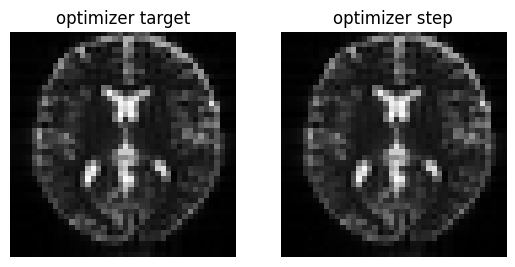

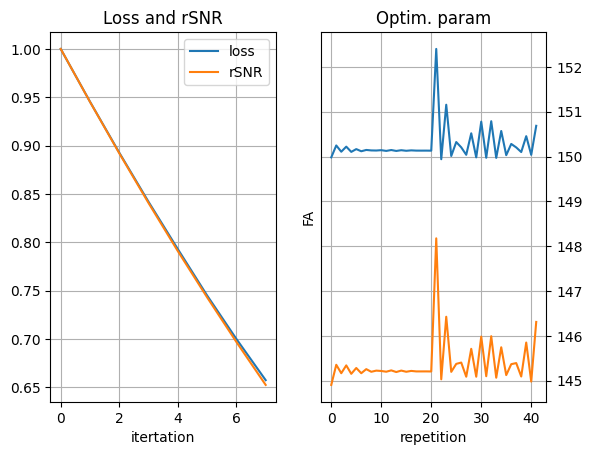

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
9 / 100: loss=0.0926312655210495, rSAR=0.6099593639373779, Ref_FA=[139.79596 140.4823  140.24031 140.5217  140.20497 140.46428 140.21658
 140.42355 140.27396 140.34802 140.31404 140.29822 140.34251 140.28354
 140.3342  140.29381 140.32169 140.30592 140.3043  140.30548 140.30286
 144.22266 140.12434 141.71188 140.45949 140.43425 140.66107 140.19951
 140.89757 140.29121 141.15402 140.30829 141.18245 140.21626 140.96283
 140.25494 140.51674 140.62485 140.11462 141.38275 139.90843 142.26585]


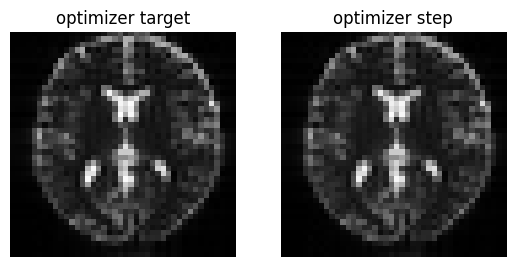

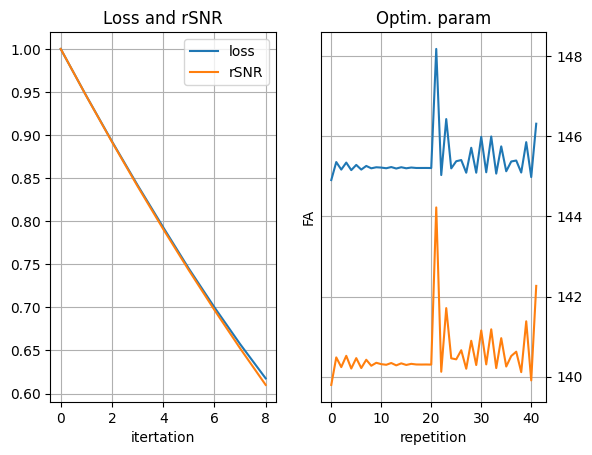

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
10 / 100: loss=0.0870581567287445, rSAR=0.5694003701210022, Ref_FA=[134.65305 135.64616 135.32954 135.7822  135.26414 135.7254  135.27187
 135.6527  135.37035 135.51155 135.44026 135.4266  135.48825 135.40465
 135.47029 135.42038 135.45511 135.43398 135.43022 135.43219 135.42798
 140.98886 135.19124 137.08618 135.79546 135.52783 135.96977 135.40536
 136.08644 135.59778 136.31177 135.6022  136.36133 135.45264 136.21303
 135.44435 135.77435 135.87263 135.23543 137.02455 134.83994 138.68723]


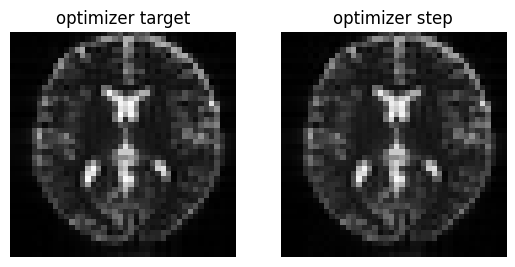

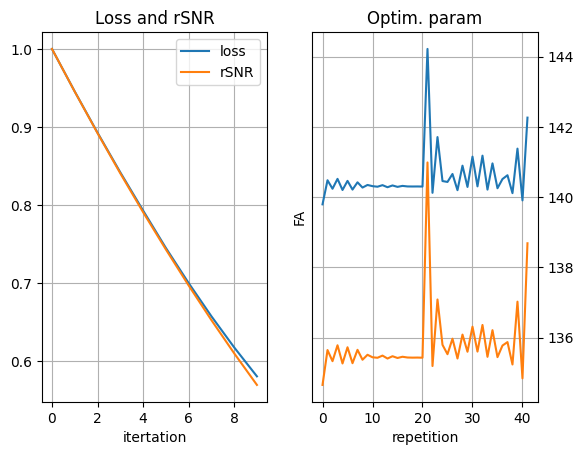

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
11 / 100: loss=0.08158411830663681, rSAR=0.5310258865356445, Ref_FA=[129.46786 130.83408 130.45615 131.10388 130.34767 131.06772 130.33969
 130.95334 130.49185 130.72322 130.59811 130.59155 130.67192 130.56035
 130.6403  130.58    130.62555 130.59357 130.5893  130.59074 130.58492
 138.84863 130.2252  132.6022  131.20685 130.69978 131.30891 130.75865
 131.29501 130.9936  131.49966 130.96428 131.52536 130.83208 131.46674
 130.73605 131.19502 131.11993 130.52646 132.82687 129.76172 135.90225]


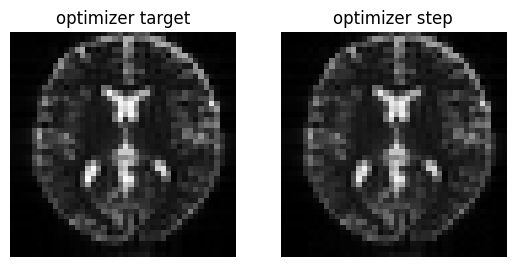

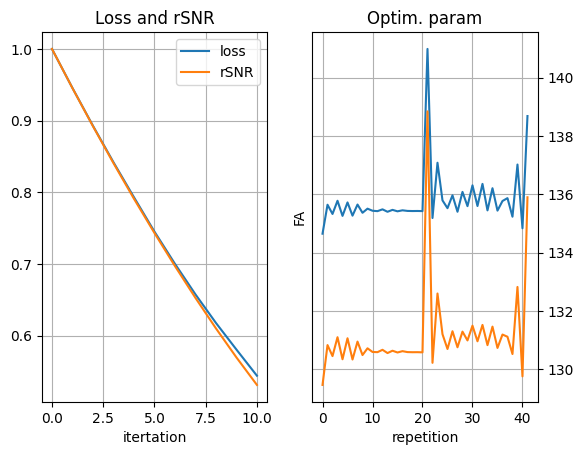

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
12 / 100: loss=0.07669074833393097, rSAR=0.4949973225593567, Ref_FA=[125.16242  125.93216  125.72668  126.43952  125.541885 126.43643
 125.46483  126.29617  125.666534 125.969955 125.80699  125.78619
 125.90494  125.75345  125.84735  125.78007  125.83328  125.791595
 125.78473  125.785904 125.7779   138.6444   125.16769  128.40773
 126.672264 125.86044  126.74058  126.151146 126.52666  126.460884
 126.70522  126.44484  126.65498  126.415825 126.64732  126.17216
 126.72477  126.27441  126.450714 128.36043  125.70886  132.43306 ]


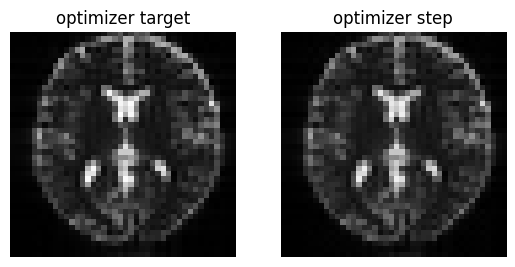

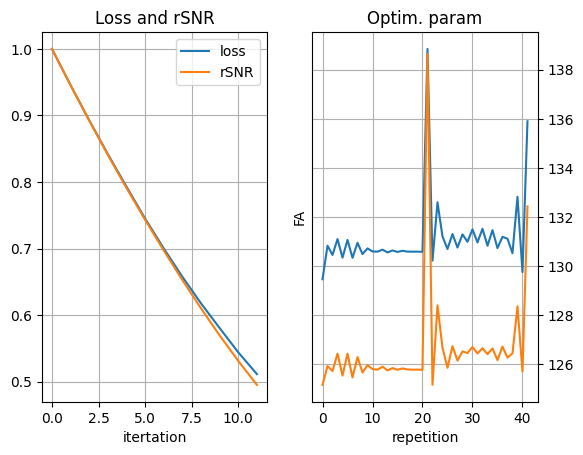

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
13 / 100: loss=0.07222257554531097, rSAR=0.4608931243419647, Ref_FA=[121.23726  120.97065  121.04881  121.90989  120.816    121.83351
 120.67531  121.65235  120.92206  121.24971  121.06822  121.02483
 121.18393  120.99358  121.0947   121.02121  121.086655 121.03072
 121.020676 121.0216   121.01097  139.10623  120.144516 124.15251
 122.34274  121.03654  122.221306 121.66963  121.77975  122.0227
 121.97251  122.00392  121.858    122.09287  121.8665   121.74614
 122.30115  121.47344  122.655655 123.75413  122.265594 128.58144 ]


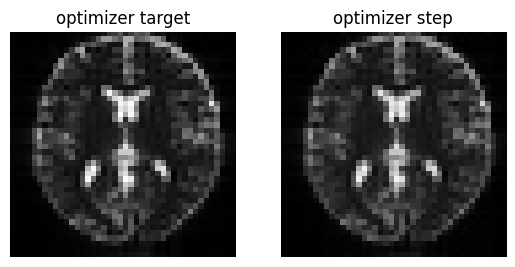

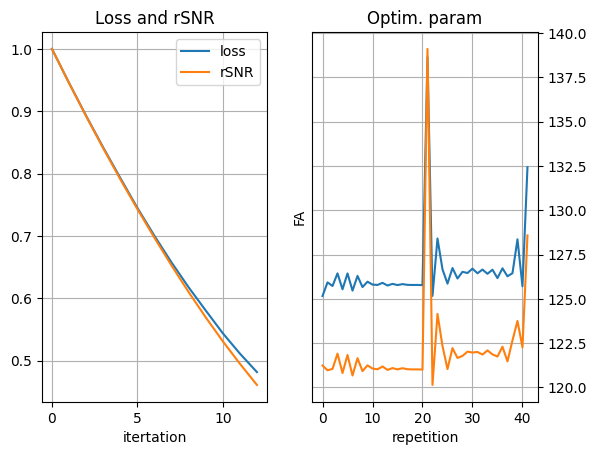

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
14 / 100: loss=0.06817734986543655, rSAR=0.42860546708106995, Ref_FA=[117.008675 115.962555 116.42537  117.44108  116.21637  117.22255
 116.022575 117.00133  116.278984 116.573685 116.37562  116.32671
 116.507126 116.28731  116.39096  116.30585  116.39083  116.31518
 116.30215  116.299965 116.28835  139.3516   115.36744  119.78971
 118.180466 116.397575 117.69194  117.4136   117.09048  117.74929
 117.278725 117.71055  117.19548  117.85276  117.19974  117.51012
 117.93104  116.81658  118.98661  119.37009  118.73508  125.351364]


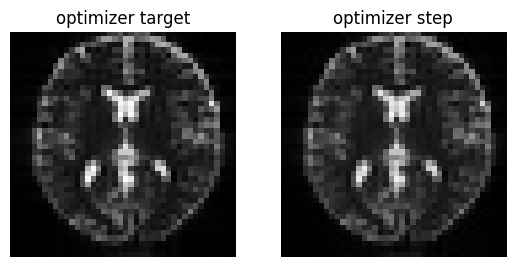

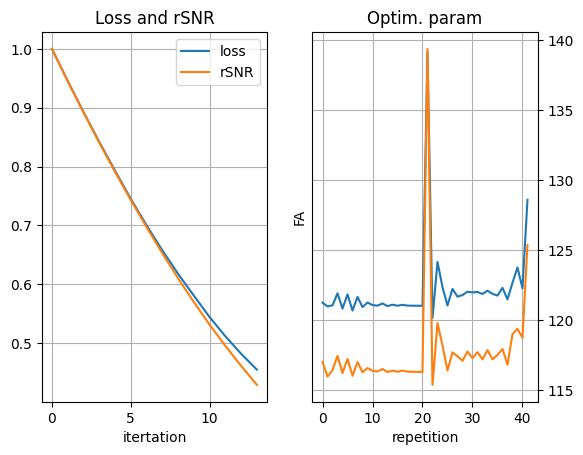

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
15 / 100: loss=0.06453914195299149, rSAR=0.3982579708099365, Ref_FA=[112.48933  110.895615 111.88343  112.98607  111.77305  112.596245
 111.5444   112.344604 111.742966 111.95912  111.72712  111.702095
 111.88222  111.637436 111.74176  111.64403  111.74867  111.648994
 111.63601  111.62345  111.615845 139.13454  110.9329   115.36337
 114.13731  112.07159  113.15284  113.444244 112.471634 113.72135
 112.58913  113.63474  112.71     113.719215 112.638664 113.58058
 113.61685  112.3246   115.56783  115.31104  115.023926 123.26887 ]


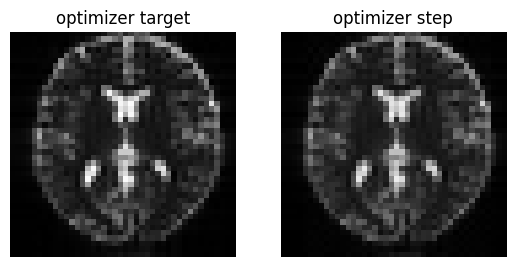

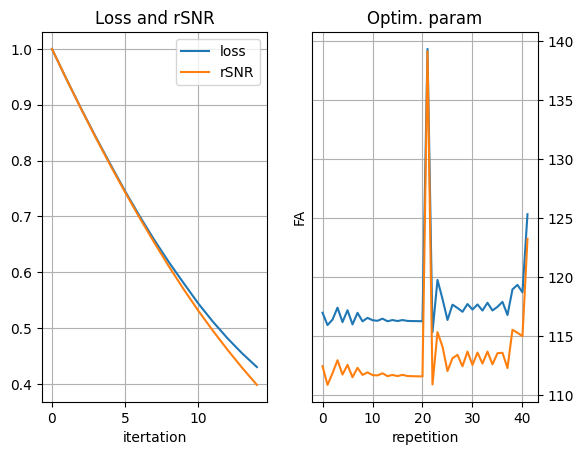

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
16 / 100: loss=0.06172966957092285, rSAR=0.36974799633026123, Ref_FA=[108.05789  105.7707   107.34764  108.69073  107.440956 107.991066
 107.26085  107.693085 107.31843  107.42148  107.124306 107.16025
 107.31651  107.051926 107.148994 107.04364  107.165405 107.039986
 107.024765 106.99777  106.997154 138.53302  106.97003  110.76874
 110.34507  108.02314  108.63283  109.70972  108.0036   109.825264
 108.02977  109.69676  108.509094 109.63598  108.30444  109.909
 109.35315  108.18278  112.28547  111.40683  111.69453  121.00223 ]


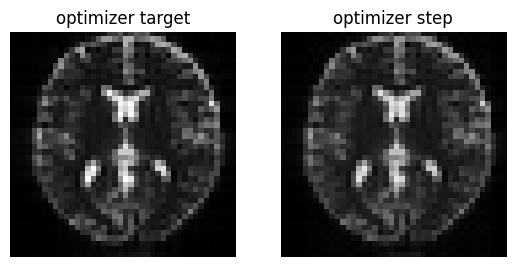

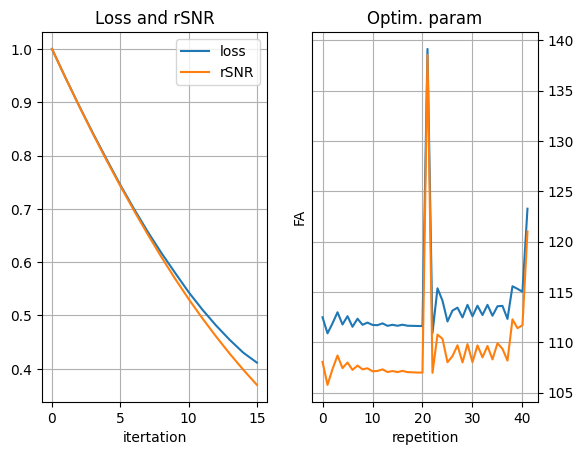

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
17 / 100: loss=0.05909193307161331, rSAR=0.3432677984237671, Ref_FA=[104.59454  100.6022   102.780014 104.546104 103.33763  103.441414
 103.08389  103.16847  102.958954 102.98895  102.576096 102.707306
 102.82375  102.53253  102.626335 102.512566 102.63614  102.50238
 102.47227  102.42298  102.440445 137.53435  103.72536  105.957306
 106.9523   104.29028  104.16564  106.027596 104.07763  105.815956
 103.91588  105.8449   104.58225  105.58259  104.45727  106.3068
 105.182976 104.659035 108.91315  107.55427  109.520164 117.922714]


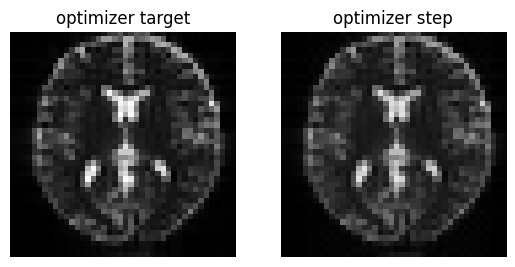

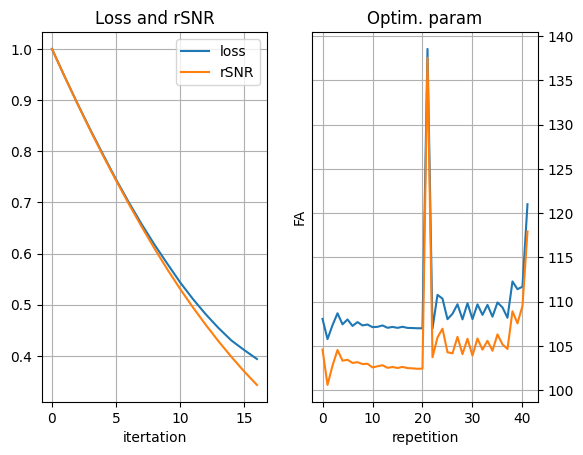

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
18 / 100: loss=0.056899525225162506, rSAR=0.3187914788722992, Ref_FA=[101.229866  95.43309   98.15199  100.557045  99.5203    98.97244
  99.004395  98.799324  98.67804   98.67409   98.08797   98.35822
  98.40919   98.092316  98.177246  98.05509   98.17216   98.041046
  97.98222   97.904724  97.95025  136.18497  101.16706  101.04805
 103.797005 101.05027   99.8118   102.44737  100.71977  101.79478
 100.229996 102.25605  100.80431  101.737976 101.13199  102.805466
 101.2362   101.76526  105.55974  103.96649  107.90273  114.61322 ]


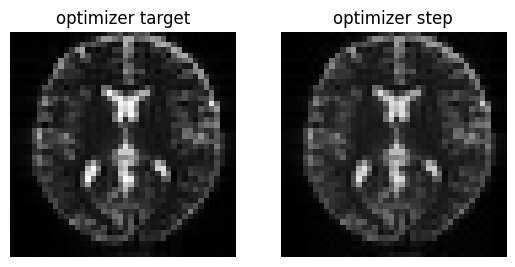

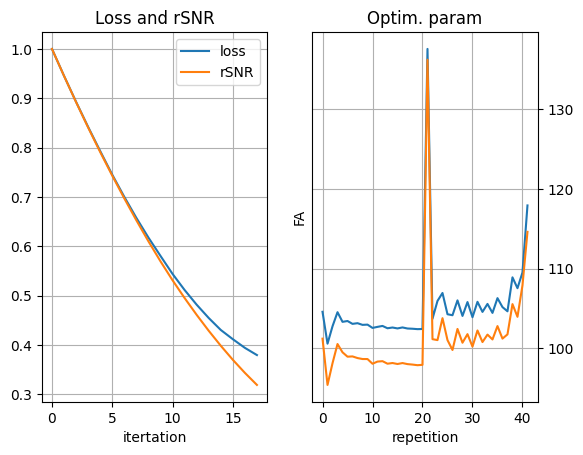

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
19 / 100: loss=0.05510381609201431, rSAR=0.29650402069091797, Ref_FA=[ 97.3702    90.30384   93.444214  96.72777   96.051186  94.61863
  95.01273   94.61685   94.491554  94.4918    93.66561   94.13007
  94.07919   93.74813   93.805595  93.67441   93.78758   93.66192
  93.557304  93.45076   93.53043  134.57205   99.21562   96.27776
 100.76052   98.3849    95.74841   99.09652   97.7975    98.00835
  96.9426    99.136986  97.12889   98.33119   98.30315   99.61588
  97.57863   99.43803  102.633965 100.73737  106.30159  112.128365]


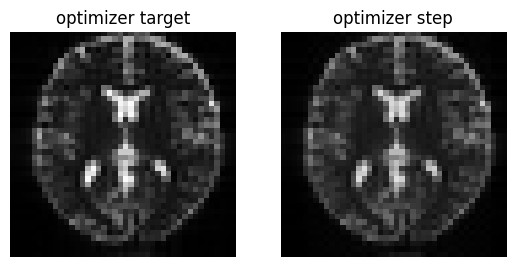

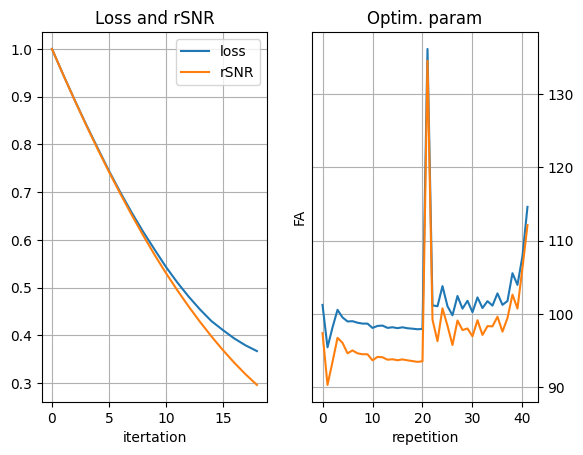

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
20 / 100: loss=0.053833361715078354, rSAR=0.2764102816581726, Ref_FA=[ 93.31164   85.258446  88.646065  93.04497   93.01651   90.430565
  91.10038   90.65316   90.424324  90.456924  89.31672   90.038246
  89.84416   89.516815  89.51787   89.37542   89.49467   89.37139
  89.20238   89.06682   89.188156 132.91948   97.74886   91.854515
  97.73104   96.17446   92.31863   95.81511   95.30286   94.530876
  94.17193   96.31377   93.72297   95.365005  95.9913    96.667854
  94.48402   97.57708  100.07824   98.04627  104.92317  109.90288 ]


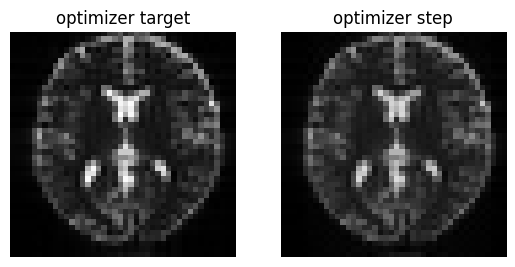

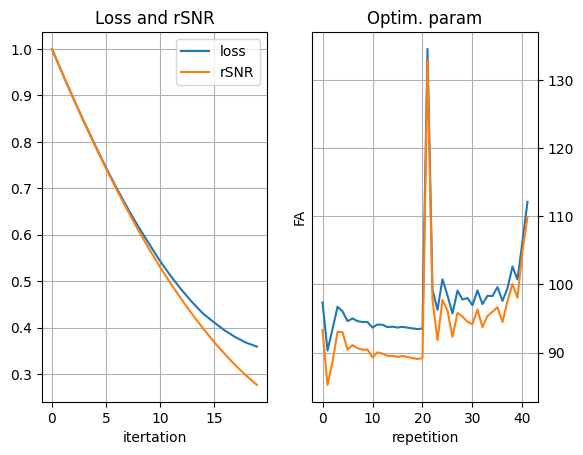

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
21 / 100: loss=0.05337776616215706, rSAR=0.25859296321868896, Ref_FA=[ 90.33457   80.40212   83.77157   89.46394   90.48494   86.49218
  87.26609   86.92895   86.50749   86.58654   85.051865  86.093346
  85.71738   85.41419   85.32019   85.169174  85.303085  85.17316
  84.9258    84.7579    84.93096  131.75223   96.470955  88.18591
  94.48979   94.16594   90.106865  92.30981   93.053116  91.5617
  91.96731   93.325165  91.03464   92.78139   93.969955  93.7526
  92.607765  95.85718   97.49527   96.40161  104.1756   106.97387 ]


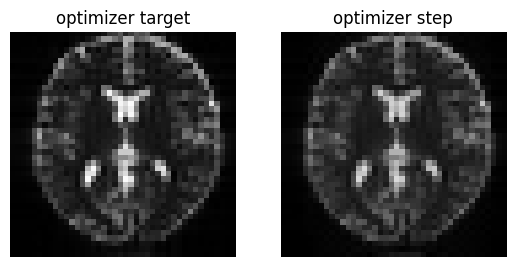

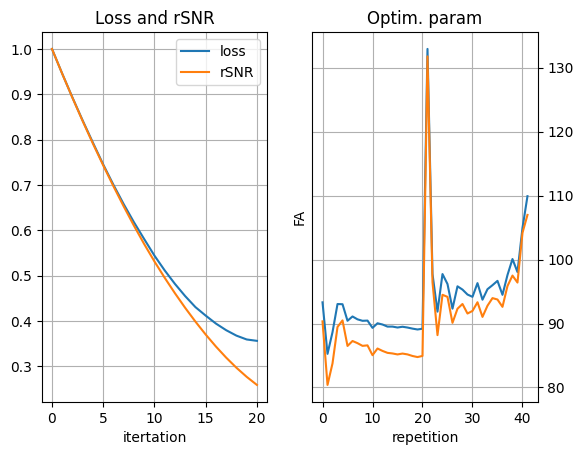

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
22 / 100: loss=0.05214456096291542, rSAR=0.2429773360490799, Ref_FA=[ 89.980034  75.85153   78.76738   85.98319   88.54816   82.8467
  83.504196  83.4824    82.7761    82.89576   80.88603   82.29072
  81.73923   81.43468   81.22461   81.06609   81.217896  81.08103
  80.729866  80.528564  80.77191  131.9804    94.4295    86.27608
  90.72835   91.90532   89.14329   88.43569   90.49463   89.0583
  90.38503   89.74175   88.64999   91.10319   91.413284  90.94963
  92.05877   93.67524   94.683495  95.89846  104.39888  103.28145 ]


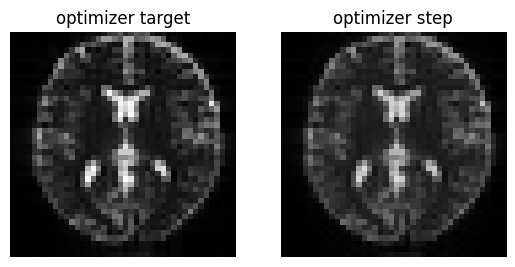

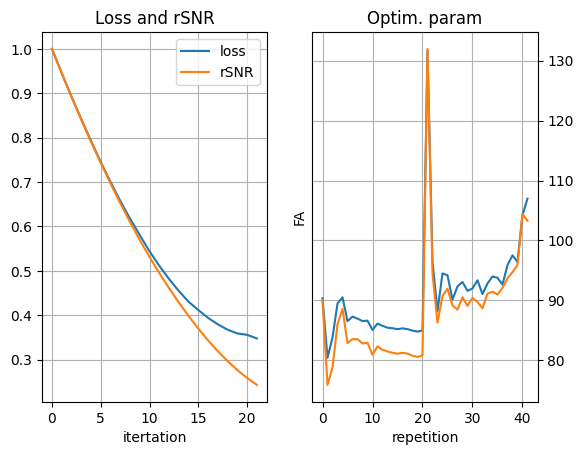

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
23 / 100: loss=0.05168931186199188, rSAR=0.22956696152687073, Ref_FA=[ 88.186134  72.01362   73.78073   82.4839    86.972984  79.71151
  79.82978   80.282104  79.24595   79.41771   76.83651   78.6326
  77.93729   77.58135   77.23955   77.08855   77.25776   77.09581
  76.62098   76.391914  76.71163  132.13463   92.77073   85.19352
  87.02967   90.08526   88.86746   85.11039   87.95164   87.38558
  89.31424   86.561806  86.51037   90.43613   89.01515   89.01529
  91.78492   91.98087   93.1309    95.31181  104.474525 101.020004]


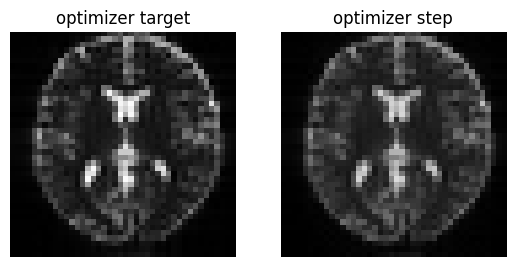

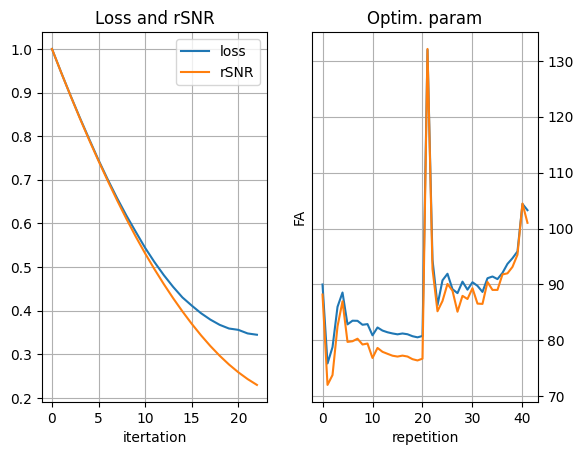

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
24 / 100: loss=0.05110016465187073, rSAR=0.21849769353866577, Ref_FA=[ 85.25839   69.166695  69.016975  78.9922    85.51932   77.24219
  76.33379   77.30119   75.920296  76.17993   72.93125   75.12856
  74.32771   73.85899   73.37533   73.26024   73.4326    73.219505
  72.6077    72.35806   72.756454 132.1884    91.71581   84.68763
  83.74772   88.91935   89.05292   82.69452   85.702995  86.53767
  88.69496   84.16781   84.75071   90.651     87.01305   87.9449
  91.609924  91.0015    92.75593   94.39943  104.25309  100.41355 ]


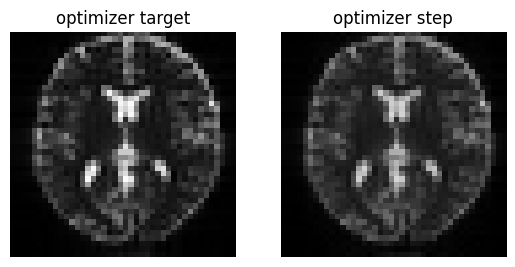

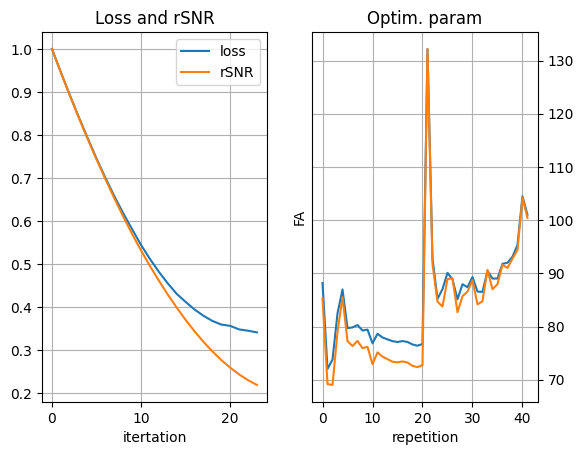

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
25 / 100: loss=0.05134329944849014, rSAR=0.209573432803154, Ref_FA=[ 82.187386  67.35815   64.73144   75.61033   83.991165  75.50821
  73.16111   74.53407   72.79866   73.18735   69.213104  71.795425
  70.91511   70.27482   69.647415  69.59512   69.74712   69.45964
  68.697266  68.43394   68.916405 132.95877   90.91812   84.043724
  81.68911   88.11802   88.94687   81.718834  83.55371   86.465645
  87.80522   82.80983   83.88191   90.7723    86.052986  87.636345
  91.42315   90.4488    92.72599   94.1798   103.71803  100.1765  ]


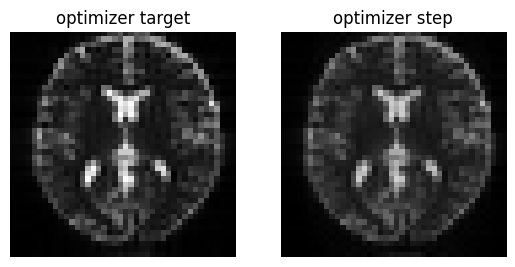

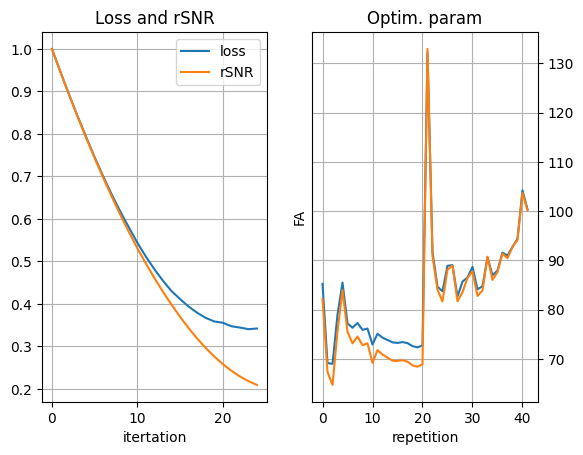

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
26 / 100: loss=0.05143776535987854, rSAR=0.20253773033618927, Ref_FA=[ 80.74738   66.43984   61.222122  72.458855  82.25344   74.4571
  70.50019   71.99519   69.872345  70.427956  65.72804   68.65217
  67.702515  66.831116  66.07155   66.09886   66.201454  65.82396
  64.89684   64.62509   65.20304  134.65791   90.20332   82.49022
  81.50113   87.32103   87.87619   82.17661   81.92186   86.55719
  86.23776   82.66536   84.27183   89.69842   86.83972   87.901
  91.17615   90.067444  92.29986   95.47572  103.06664   99.06514 ]


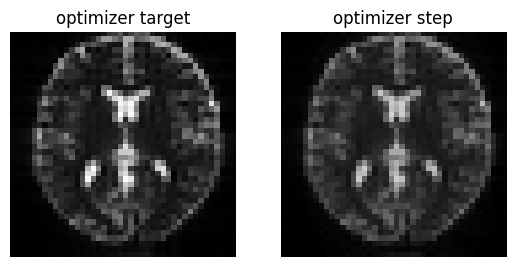

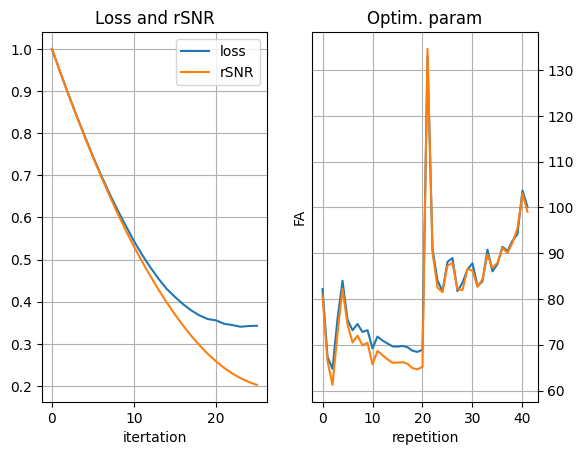

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
27 / 100: loss=0.05100952833890915, rSAR=0.1970759779214859, Ref_FA=[ 79.750305  66.59833   58.724865  69.77018   80.2172    73.965034
  68.53797   69.68964   67.16528   67.81904   62.556087  65.77158
  64.64842   63.56894   62.700542  62.73611   62.80905   62.33749
  61.21475   60.938164  61.619904 136.0859    90.25938   80.18844
  82.16159   86.846275  86.30621   83.18056   81.56793   86.17266
  84.516754  83.44987   85.26546   87.94719   88.390495  88.76312
  90.85579   90.372406  91.963066  97.255936 102.703125  97.764725]


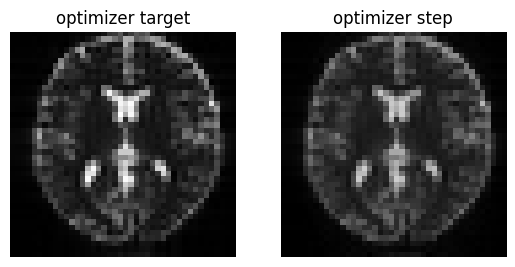

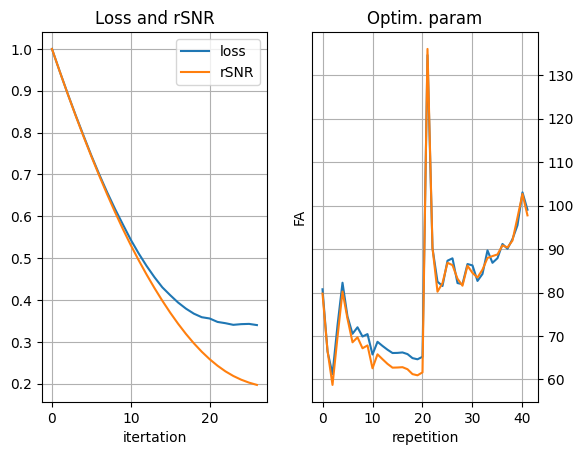

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
28 / 100: loss=0.05090231075882912, rSAR=0.19301456212997437, Ref_FA=[ 78.905754  67.442116  57.41088   67.66533   77.89093   73.81579
  67.34279   67.68492   64.66023   65.3397    59.707253  63.168827
  61.772884  60.500156  59.540222  59.521355  59.57475   59.00774
  57.65939   57.384514  58.1749   136.78294   90.959755  78.0091
  82.94755   86.585846  84.98672   84.25228   82.24059   85.25865
  83.38364   84.69743   86.28516   86.43279   90.05601   90.08174
  90.85847   91.05772   92.07002   99.09853  102.72943   96.46854 ]


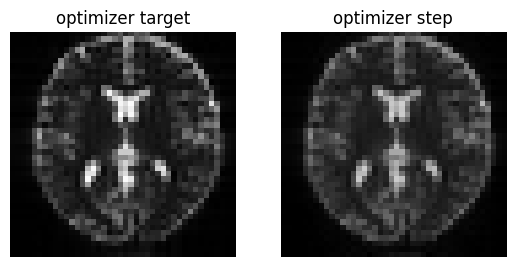

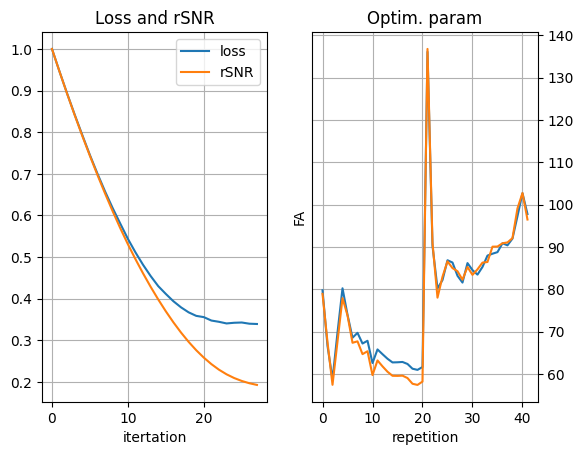

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
29 / 100: loss=0.05080781877040863, rSAR=0.1902162730693817, Ref_FA=[ 78.19058   68.68801   57.251293  66.2384    75.41017   73.780495
  66.890114  66.05845   62.369934  62.982     57.172028  60.84702
  59.096416  57.644966  56.592453  56.471745  56.503036  55.84087
  54.238365  53.977825  54.87559  136.74979   92.014015  76.92672
  83.23176   86.28031   84.63858   85.055756  83.43456   84.057556
  83.29562   85.98031   86.93178   85.90218   91.252495  91.7183
  91.5495    91.72303   92.84749  100.78956  103.15296   95.21735 ]


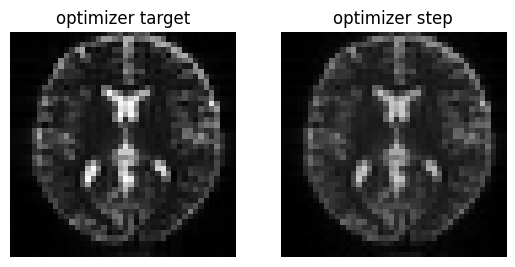

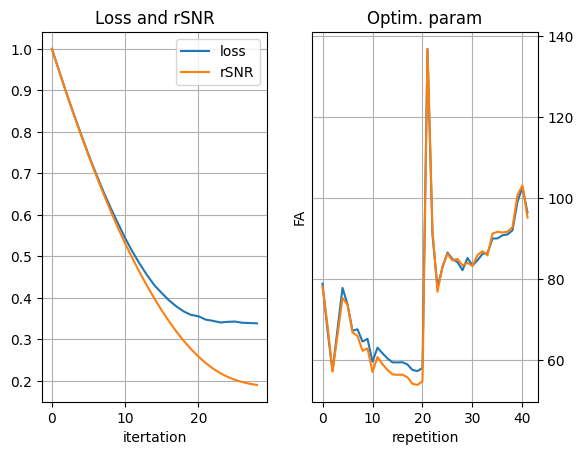

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
30 / 100: loss=0.050395842641592026, rSAR=0.18850381672382355, Ref_FA=[ 77.689186  70.11812   58.071648  65.52874   72.99523   73.660515
  67.06654   64.8724    60.33963   60.74908   54.931126  58.79929
  56.633667  55.02619   53.863625  53.60247   53.59755   52.84203
  50.95965   50.729973  51.728474 136.31683   93.07795   77.30551
  82.717064  85.74577   85.44409   85.53183   84.55275   83.05885
  84.177475  86.99351   87.16099   86.50752   91.73884   93.55141
  93.02222   92.11719   94.31371  102.302734 103.87086   94.01166 ]


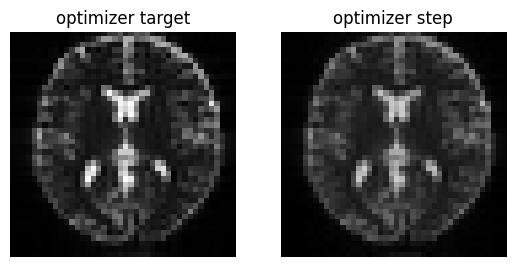

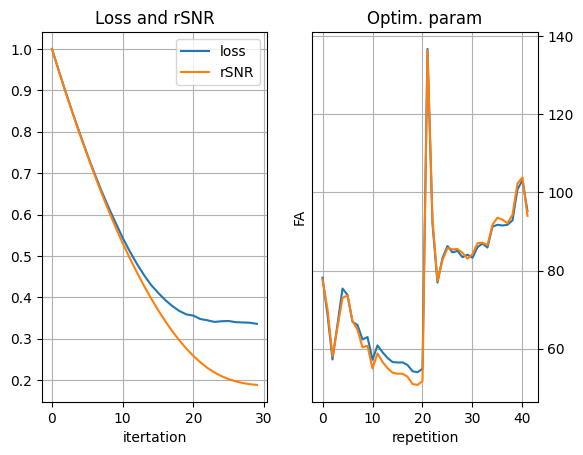

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
31 / 100: loss=0.04940707981586456, rSAR=0.18780949711799622, Ref_FA=[ 77.31888   71.552536  59.64961   65.50006   70.89558   73.3265
  67.6999    64.15072   58.632366  58.659466  52.964764  57.01049
  54.390003  52.660683  51.367405  50.927982  50.86117   50.016747
  47.83139   47.649784  48.73916  135.921     93.937164  78.77187
  81.595764  85.081764  87.04618   85.94868   85.135635  82.80345
  85.633484  87.71614   87.27041   87.90195   91.82083   95.47157
  95.04934   92.451035  96.29568  103.70939  104.68246   93.00224 ]


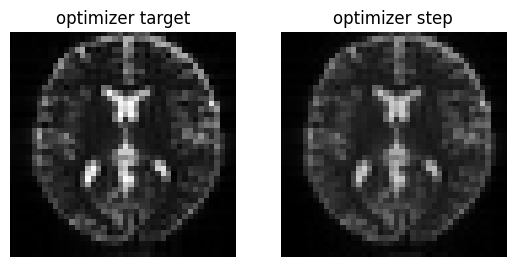

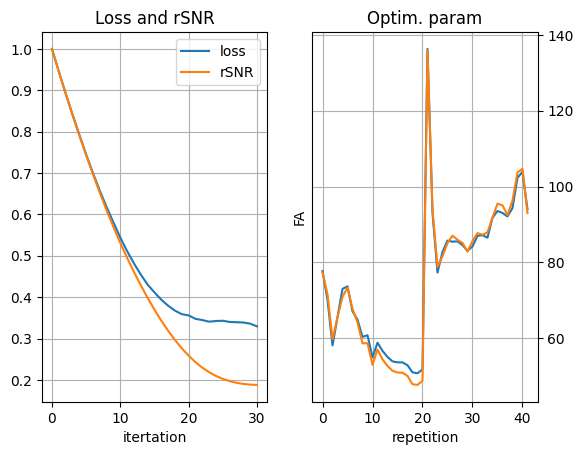

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
32 / 100: loss=0.04917219653725624, rSAR=0.18784315884113312, Ref_FA=[ 77.20041   72.52342   61.82965   65.90979   69.301254  72.72766
  68.59429   63.89519   57.27636   56.781033  51.220596  55.43238
  52.421463  50.535957  49.036057  48.47961   48.33456   47.36825
  44.854298  44.744137  45.914497 135.81079   94.72858   80.527985
  80.42896   84.42309   88.93638   86.43073   85.33575   83.298676
  87.09484   88.249794  87.49565   89.37405   92.38716   96.40409
  97.72308   92.79626   98.22009  105.15807  105.40511   92.02572 ]


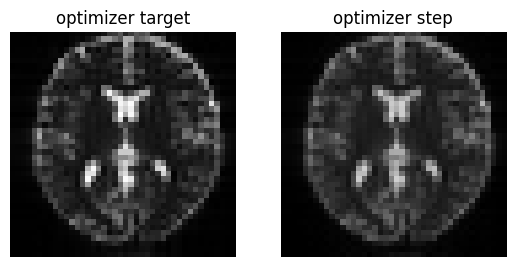

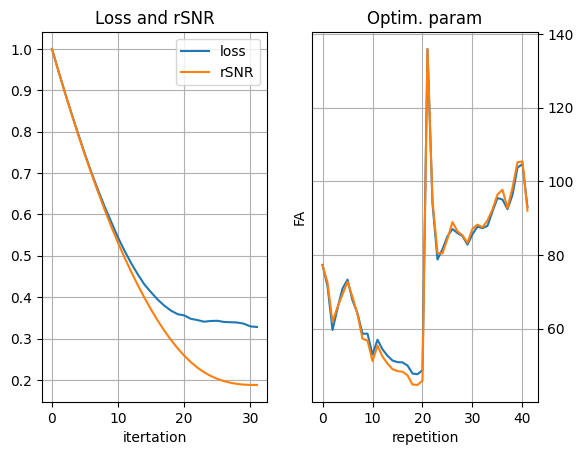

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
33 / 100: loss=0.04905965179204941, rSAR=0.1886742264032364, Ref_FA=[ 77.17681   73.10339   64.384735  66.69949   68.4238    71.912186
  69.54525   64.07042   56.325947  55.157406  49.694572  54.04789
  50.71741   48.658813  46.88454   46.266518  46.02147   44.911522
  42.04114   42.018406  43.258926 136.2304    95.50785   82.03921
  79.69047   84.26462   90.48973   87.250755  85.53378   84.355
  88.201256  88.904625  88.077515  90.57518   93.65035   96.729546
 100.44824   93.72897   99.83881  106.735146 105.84303   91.26916 ]


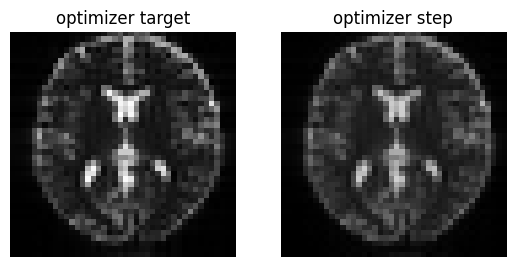

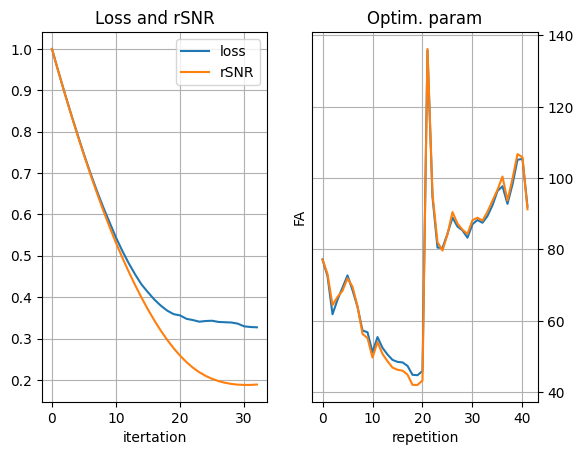

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
34 / 100: loss=0.04885275661945343, rSAR=0.19025318324565887, Ref_FA=[ 77.25183   73.45461   67.10282   67.78729   68.37389   70.9892
  70.37817   64.599945  55.809326  53.84294   48.384296  52.848198
  49.259888  47.02626   44.929436  44.295185  43.92471   42.657528
  39.407043  39.476135  40.77788  137.2535    96.34718   82.90516
  79.68941   84.80643   91.37419   88.4471    86.115166  85.70438
  88.84172   89.84163   89.07541   91.38549   95.43505   96.97099
 102.61394   95.446556 101.05686  108.48177  105.89545   90.76878 ]


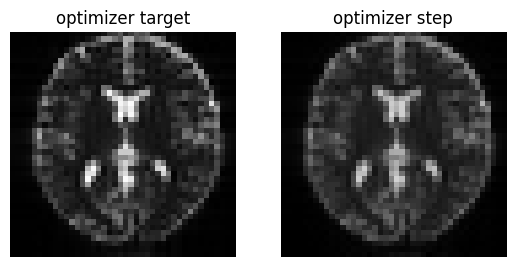

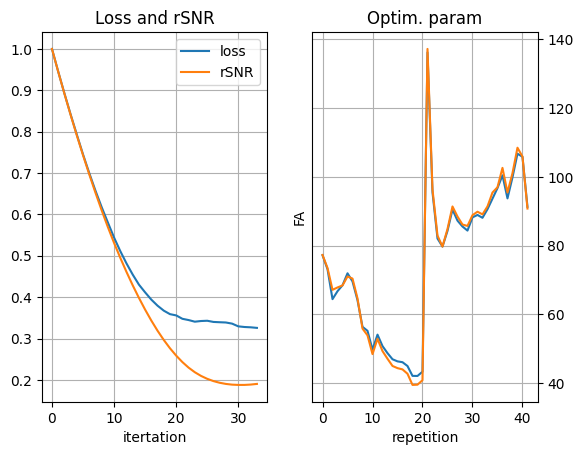

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
35 / 100: loss=0.048580870032310486, rSAR=0.19244767725467682, Ref_FA=[ 77.4801    73.72662   69.78162   69.07964   69.125984  70.092766
  70.97971   65.36824   55.71772   52.891964  47.29167   51.828796
  48.02541   45.627556  43.183582  42.568726  42.046555  40.61223
  36.965088  37.12002   38.47674  138.7307    97.29174   83.06538
  80.42731   85.86305   91.71237   89.84734   87.23834   87.11216
  89.192986  90.9907    90.38416   91.9689    97.31401   97.58111
 103.945244  97.73711  102.05968  110.31361  105.58981   90.47919 ]


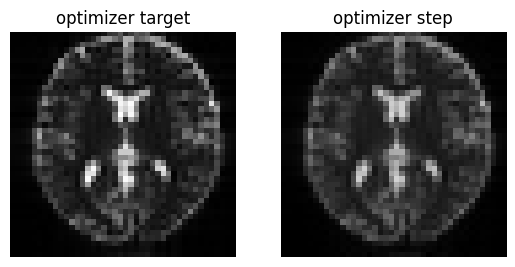

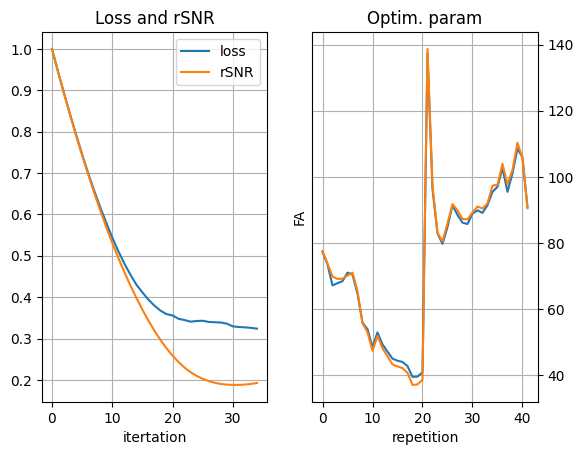

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
36 / 100: loss=0.04936441034078598, rSAR=0.1950608789920807, Ref_FA=[ 77.914444  74.02884   72.24633   70.489525  70.554695  69.35222
  71.305664  66.24072   56.01171   52.343987  46.420452  50.98682
  46.989773  44.44949   41.651176  41.08676   40.386745  38.78002
  34.72216   34.95449   36.35858  140.36383   98.323555  82.7656
  81.66399   87.03579   91.88091   91.18829   88.78275   88.445045
  89.56673   92.11519   91.80018   92.62972   98.77649   98.71729
 104.64374  100.128914 103.213585 112.04008  105.0422    90.31985 ]


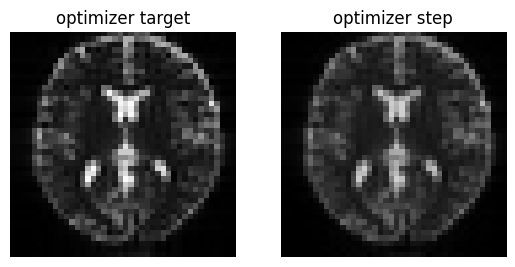

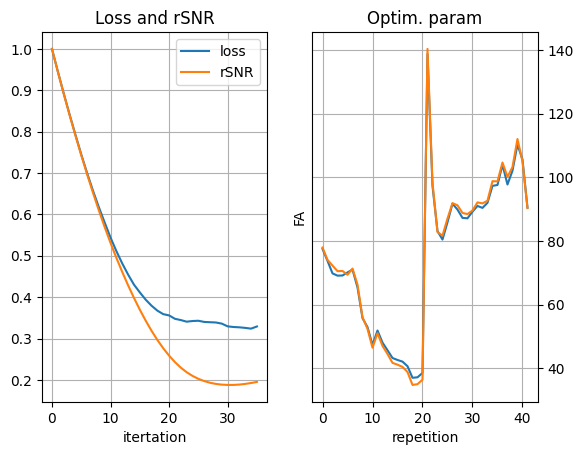

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
37 / 100: loss=0.0490025132894516, rSAR=0.19795921444892883, Ref_FA=[ 78.67779   74.492256  74.42811   72.24039   72.44374   69.25216
  71.06112   67.17362   56.698936  52.229763  45.763683  50.357807
  46.114937  43.440807  40.381622  39.89325   38.903385  37.16187
  32.673378  32.9916    34.428246 141.83542   99.562164  82.19956
  82.870316  88.405655  91.9591    92.47382   90.23651   89.767654
  90.244125  92.867     93.29293   93.76454   98.91737  101.05836
 104.229195 102.48894  105.01351  113.27178  104.563324  90.198875]


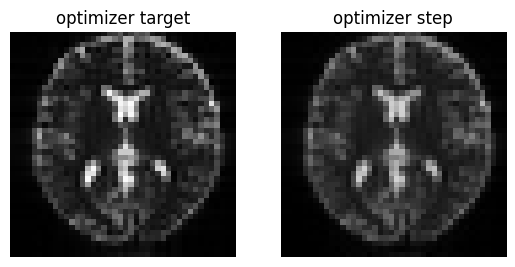

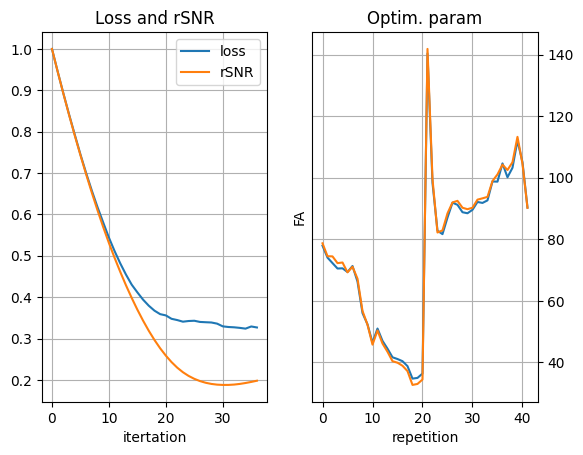

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
38 / 100: loss=0.0488104373216629, rSAR=0.20109829306602478, Ref_FA=[ 79.553154  75.237175  76.27267   74.27975   74.61287   69.715096
  70.4378    68.0243    57.692444  52.524048  45.339146  49.92735
  45.40202   42.586754  39.370785  38.97642   37.605988  35.758293
  30.825903  31.235577  32.685432 143.01514  100.86967   81.84937
  83.837234  89.650665  92.32024   93.56919   91.54811   91.092255
  91.278145  93.39803   94.54651   95.336334  98.44332  103.76356
 103.65888  104.36977  107.402596 113.97789  104.189766  90.2     ]


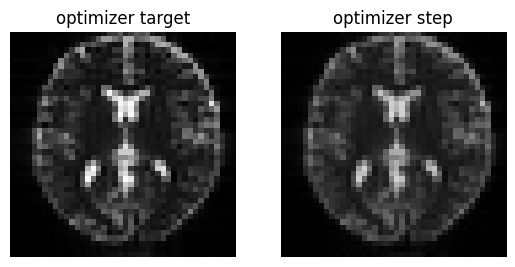

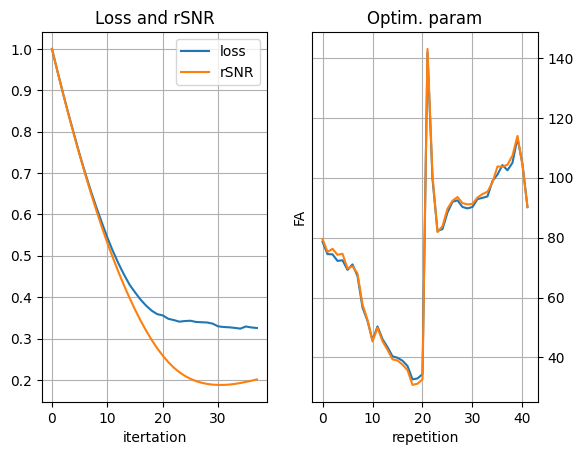

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
39 / 100: loss=0.048755064606666565, rSAR=0.20437537133693695, Ref_FA=[ 80.47325   76.31898   77.78127   76.54143   76.88175   70.61949
  69.664635  68.66552   58.901726  53.17945   45.159187  49.681305
  44.854553  41.875854  38.609146  38.319534  36.501286  34.56906
  29.185646  29.688864  31.12814  143.9158   102.05187   82.03663
  84.45716   90.525406  93.13233   94.401924  92.69771   92.41358
  92.5395    93.91589   95.38572   97.08237   98.118675 105.90418
 103.68869  105.53216  110.12261  114.328835 103.84131   90.31855 ]


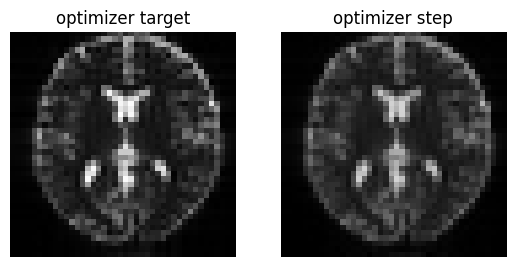

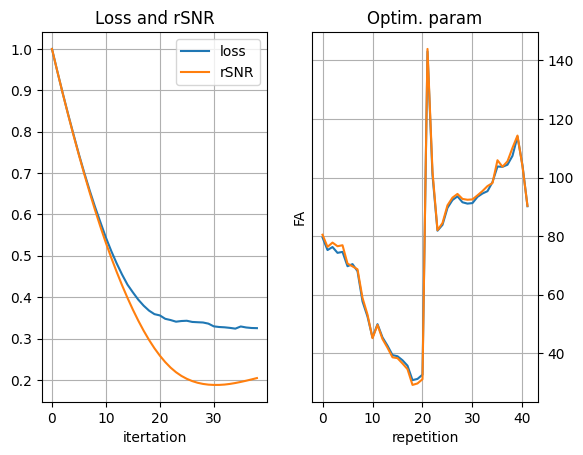

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
40 / 100: loss=0.048647329211235046, rSAR=0.207662433385849, Ref_FA=[ 81.43993   77.721214  79.005     78.94479   79.08039   71.83947
  68.956436  69.024765  60.232723  54.12981   45.22564   49.609425
  44.47762   41.30079   38.0809    37.900528  35.58958   33.592968
  27.75723   28.352192  29.754084 144.58266  102.96989   82.827705
  84.731895  90.97354   94.33405   95.001175  93.67947   93.70778
  93.84397   94.566     95.85233   98.63344   98.547874 106.80959
 104.577324 106.11792  112.7786   114.565475 103.40831   90.50581 ]


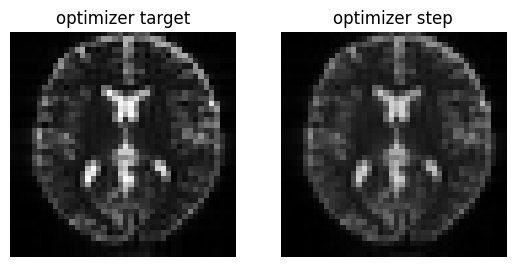

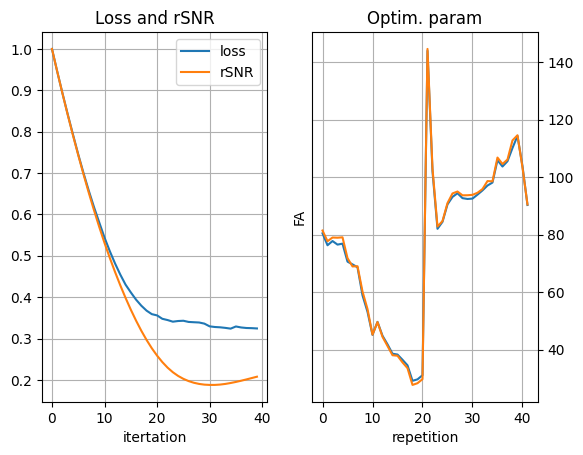

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
41 / 100: loss=0.04839150607585907, rSAR=0.21089379489421844, Ref_FA=[ 82.31634   79.3361    80.02932   81.39512   81.05857   73.26122
  68.464554  69.10297   61.589527  55.29858   45.52982   49.710392
  44.275524  40.857407  37.76651   37.696167  34.86718   32.82646
  26.542482  27.222498  28.561903 144.99063  103.664215  84.04953
  84.77045   91.18858   95.681725  95.53524   94.48391   94.96564
  95.06793   95.3934    96.121895  99.74936   99.81668  106.637436
 105.99332  106.61709  114.964836 114.83805  102.85215   90.81829 ]


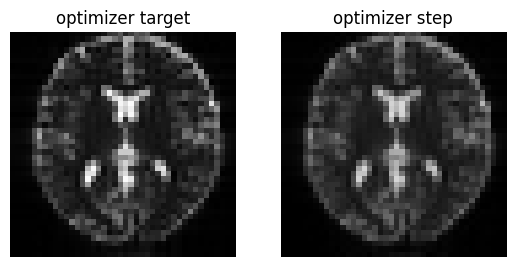

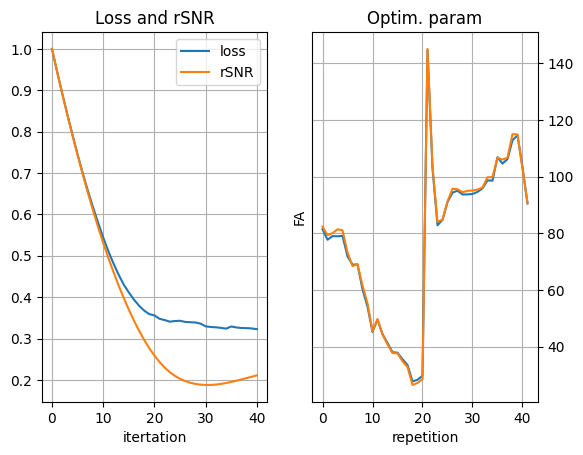

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
42 / 100: loss=0.04833288863301277, rSAR=0.21392886340618134, Ref_FA=[ 82.91986   81.03358   80.94807   83.561134  82.72177   74.74318
  68.30525   68.9859    62.839535  56.592487  46.06276   49.960266
  44.257626  40.57798   37.622604  37.62355   34.32167   32.272385
  25.547417  26.290474  27.544643 145.04584  104.11089   85.57768
  84.68541   91.310646  96.92783   96.16877   95.082756  96.12589
  96.207375  96.334816  96.296715 100.43664  101.61588  105.899124
 107.37643  107.47153  116.44086  115.135994 102.22139   91.32281 ]


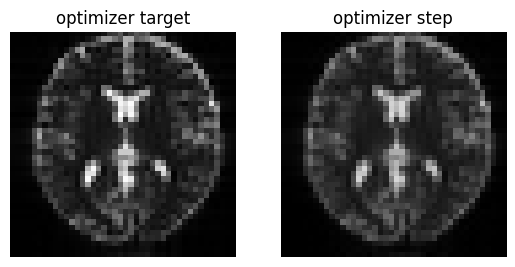

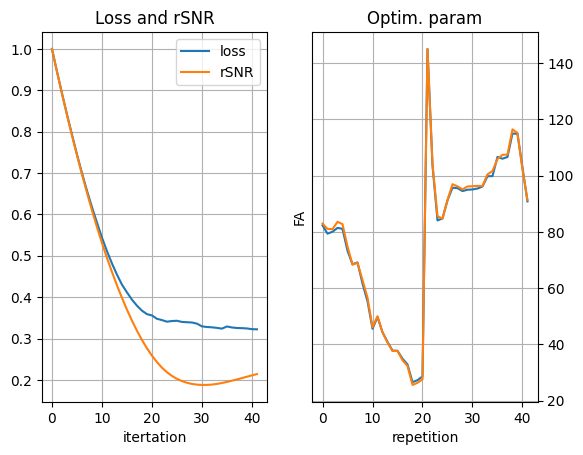

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
43 / 100: loss=0.04833817481994629, rSAR=0.21674658358097076, Ref_FA=[ 83.248505  82.64527   81.8507    85.4015    84.04971   76.20077
  68.48787   68.75944   63.91147   57.94179   46.803856  50.355583
  44.41493   40.453327  37.632256  37.66669   33.9434    31.925194
  24.767273  25.55019   26.697235 144.74792  104.4584    87.11541
  84.654144  91.50062   97.879875  96.99058   95.53871   97.11342
  97.32964   97.275986  96.500854 100.815445 103.57768  105.07798
 108.29456  108.84581  117.22888  115.357994 101.68069   91.977615]


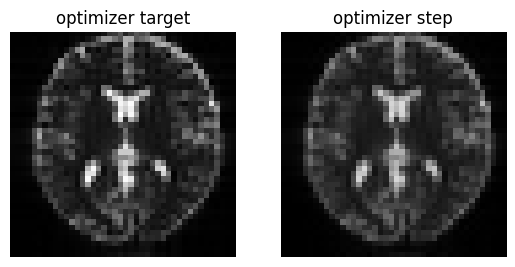

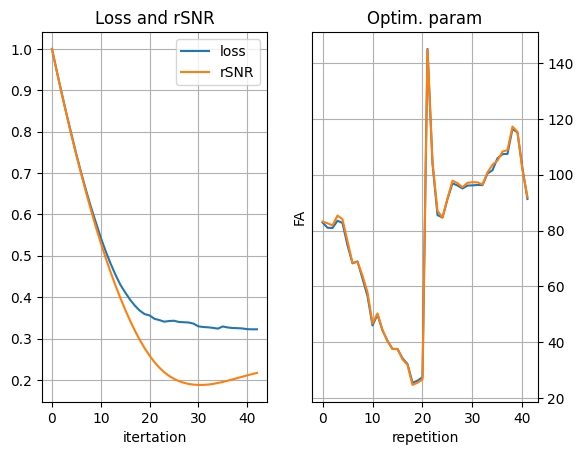

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
44 / 100: loss=0.04838204011321068, rSAR=0.2192838490009308, Ref_FA=[ 83.51005   84.014336  82.79778   86.8848    85.0884    77.538895
  68.988495  68.52338   64.75999   59.281517  47.725998  50.884098
  44.73133   40.47455   37.779625  37.80805   33.72233   31.775253
  24.194696  24.993853  26.011578 144.1738   104.769035  88.39849
  84.832214  91.75399   98.45151   97.96787   95.929634  97.81404
  98.50613   98.06457   96.788895 101.04239  105.30472  104.54415
 108.52468  110.65658  117.45066  115.38212  101.413086  92.5699  ]


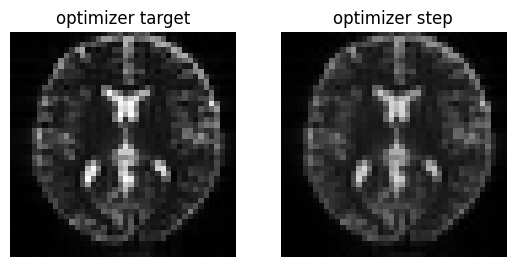

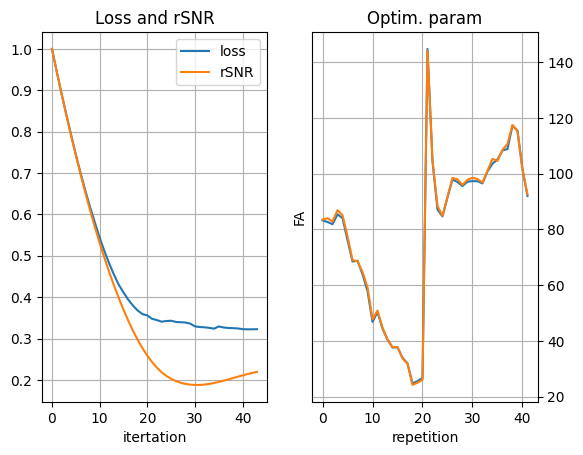

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
45 / 100: loss=0.048396892845630646, rSAR=0.2214871495962143, Ref_FA=[ 83.92679   85.02342   83.80872   87.99985   85.91783   78.665
  69.762085  68.37174   65.36813   60.551155  48.796932  51.52869
  45.187046  40.631374  38.049385  38.031998  33.648487  31.810213
  23.820454  24.611223  25.47893  143.47154  105.03108   89.26244
  85.3183    91.96706   98.67833   98.976555  96.3291    98.178406
  99.72792   98.61826   97.11575  101.29978  106.4491   104.498535
 108.13019  112.61799  117.35376  115.074715 101.54598   92.895424]


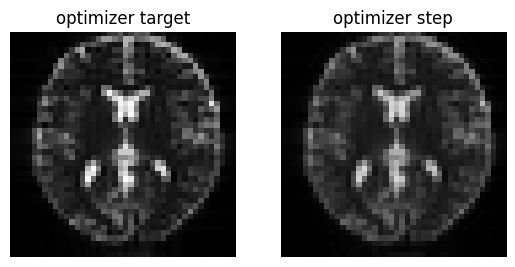

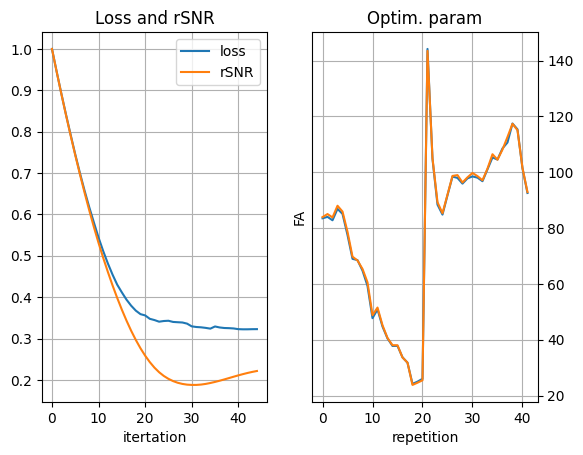

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
46 / 100: loss=0.04838874191045761, rSAR=0.22335003316402435, Ref_FA=[ 84.53895   85.62914   84.85569   88.76164   86.61957   79.507385
  70.74846   68.373764  65.74677   61.700565  49.980274  52.26663
  45.762096  40.915363  38.426456  38.325066  33.71198   32.01595
  23.633818  24.391531  25.08989  142.81311  105.1857    89.71651
  86.09212   92.06808   98.682655  99.85924   96.77934   98.30909
 100.84109   99.01015   97.36537  101.71581  106.90283  104.89542
 107.42727  114.30834  117.25131  114.367134 102.02929   92.96251 ]


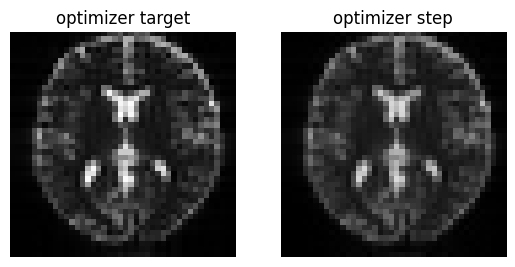

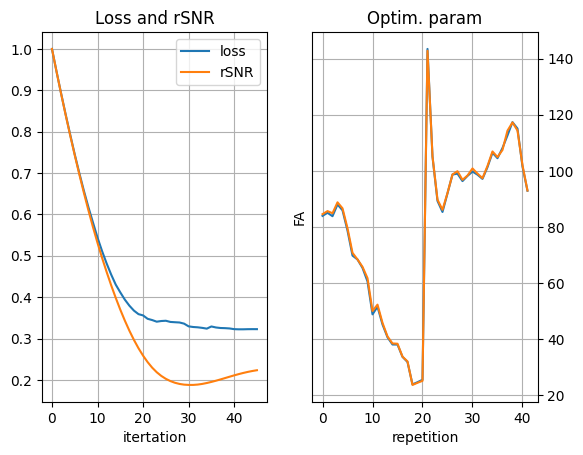

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
47 / 100: loss=0.048388440161943436, rSAR=0.22495028376579285, Ref_FA=[ 85.24141   85.82399   85.89556   89.13351   87.346565  79.92868
  71.8502    68.682236  65.89662   62.614586  51.24595   53.14537
  46.38865   41.37699   38.878487  38.641586  33.94812   32.330795
  23.604366  24.311148  24.837645 142.38693  105.1746    89.91228
  86.97968   92.20345   98.586494 100.4792    97.348145  98.40842
 101.599976  99.4474    97.44679  102.297325 106.85352  105.468506
 106.87544  115.400604 117.25152  113.56074  102.50781   92.98405 ]


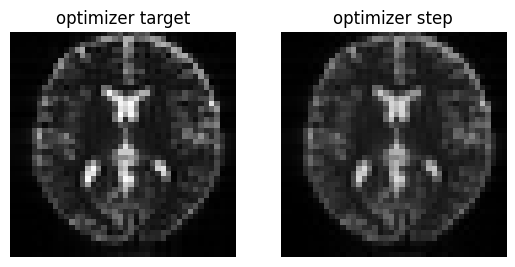

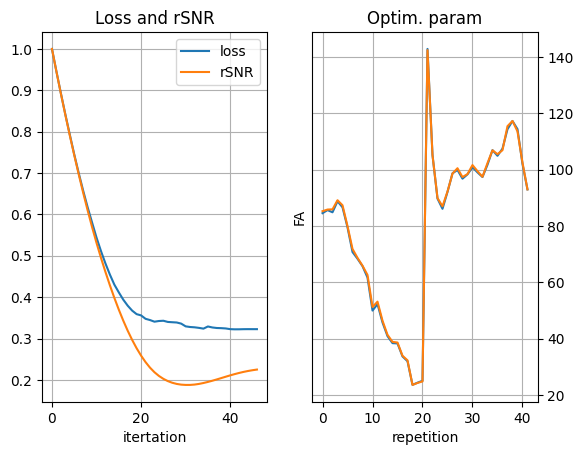

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
48 / 100: loss=0.04837271198630333, rSAR=0.22633303701877594, Ref_FA=[ 85.85602   85.712875  86.839485  89.2119    88.0961    79.96982
  72.997795  69.27437   65.876144  63.288345  52.553318  54.12423
  47.055286  41.999046  39.3915    38.97496   34.341087  32.74262
  23.721247  24.36192   24.714834 142.20699  104.98453   90.00175
  87.83398   92.452866  98.47     100.809     97.97806   98.64813
 101.88519   99.99228   97.44754  102.91861  106.53889  105.99976
 106.70622  115.78274  117.41167  112.7718   102.769516  93.17449 ]


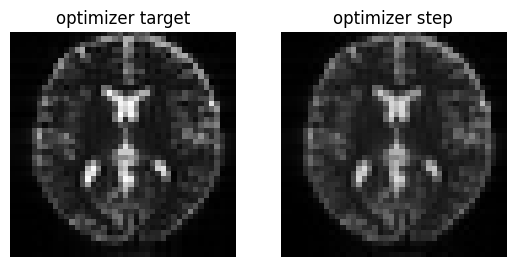

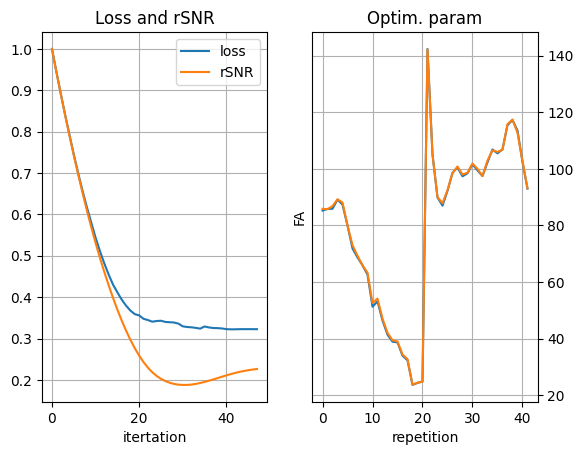

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
49 / 100: loss=0.04832807555794716, rSAR=0.22752512991428375, Ref_FA=[ 86.271126  85.42205   87.58631   89.121605  88.80734   79.72669
  74.11136   70.097626  65.75365   63.731655  53.860714  55.158485
  47.753365  42.76151   39.95153   39.317738  34.8722    33.237137
  23.971943  24.534271  24.714092 142.2048   104.648224  90.081474
  88.54972   92.87051   98.36366  100.880684  98.59658   99.089455
 101.73832  100.58333   97.54875  103.411194 106.17494  106.34351
 106.955574 115.56088  117.63486  112.13811  102.68509   93.641396]


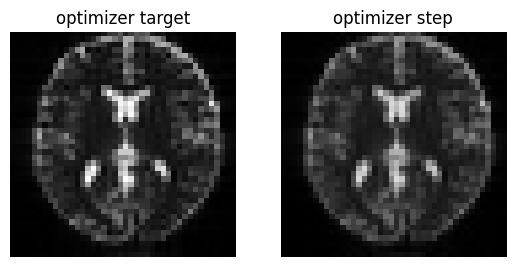

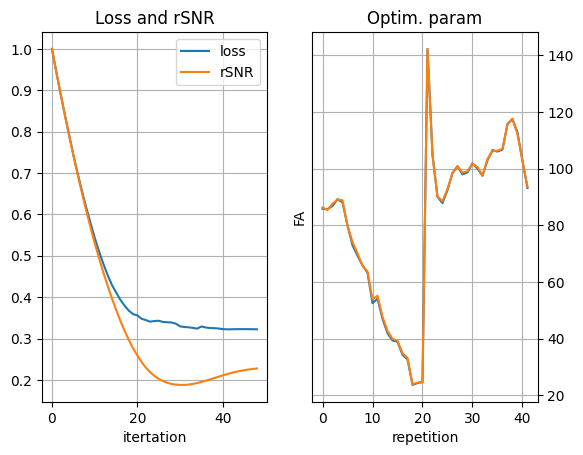

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
50 / 100: loss=0.04826948791742325, rSAR=0.2285224199295044, Ref_FA=[ 86.4944    85.05908   88.0478    88.984474  89.38766   79.32774
  75.10661   71.081024  65.59854   63.967365  55.127132  56.20428
  48.475803  43.639374  40.54464   39.662132  35.519382  33.798332
  24.341476  24.81867   24.828075 142.27507  104.222374  90.175934
  89.08868   93.43945   98.27091  100.742516  99.14922   99.67212
 101.32443  101.07009   97.92992  103.63551  105.8979   106.44434
 107.520386 114.94559  117.73905  111.77101  102.2486    94.3461  ]


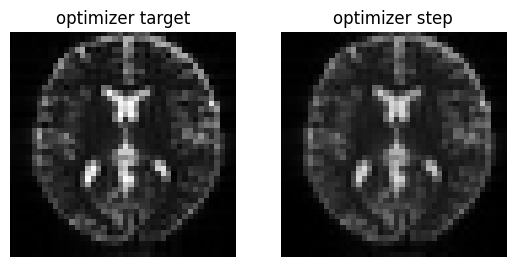

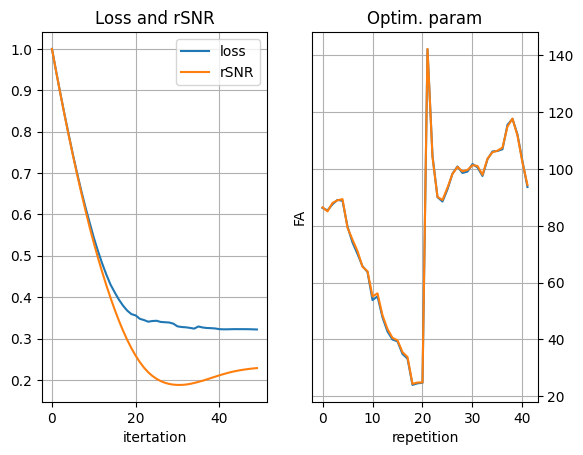

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
51 / 100: loss=0.04830658808350563, rSAR=0.2292945384979248, Ref_FA=[ 86.62861   84.70154   88.17207   88.87994   89.74924   78.909874
  75.90982   72.13929   65.472084  64.03245   56.314354  57.21888
  49.215252  44.606953  41.15605   40.000088  36.259933  34.40928
  24.81407   25.203352  25.048874 142.30998  103.769485  90.25108
  89.475716  94.072624  98.1853   100.43887   99.61229  100.25064
 100.86213  101.28836   98.67223  103.5383   105.73755  106.33566
 108.21646  114.17172  117.53693  111.70985  101.587234  95.12828 ]


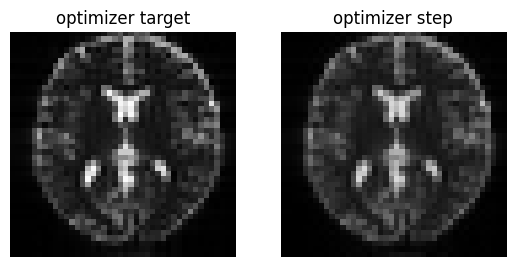

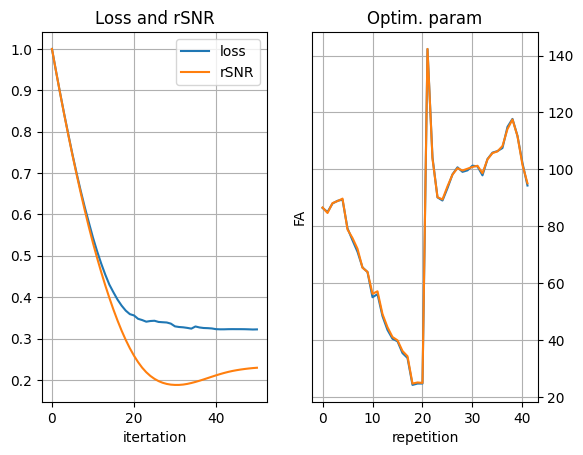

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
52 / 100: loss=0.04828104376792908, rSAR=0.22975650429725647, Ref_FA=[ 86.73922   84.46065   87.8702    88.97737   89.72872   78.65412
  76.50729   73.06038   65.44432   64.06861   57.375893  58.042572
  50.056892  45.594044  41.776142  40.386753  37.06265   35.072887
  25.382538  25.678568  25.362526 142.13676  103.36955   90.24921
  89.82389   94.49833   98.181885 100.00328   99.909096 100.760056
 100.45741  101.19284   99.68517  103.17756  105.614685 106.15872
 108.79781  113.40083  117.00864  111.6586   100.94366   95.804504]


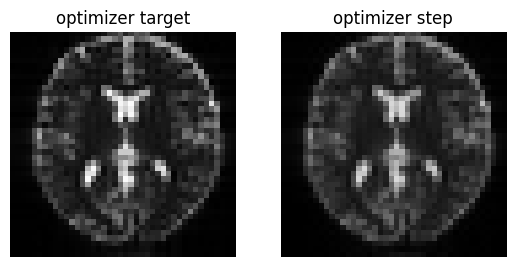

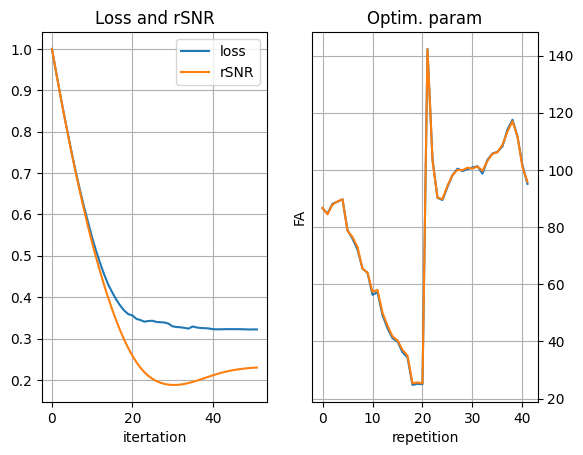

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
53 / 100: loss=0.04825183004140854, rSAR=0.2299049198627472, Ref_FA=[ 86.9032    84.34636   87.20854   89.191605  89.36198   78.62479
  76.867516  73.78252   65.54021   64.11454   58.284927  58.667
  50.979935  46.57948   42.396175  40.8151    37.90782   35.771744
  26.031616  26.231146  25.758484 141.75569  103.0401    90.13906
  90.16962   94.71701   98.19499   99.51814  100.065346 101.05627
 100.22681  100.841225 100.69897  102.73283  105.39972  106.03037
 109.11216  112.75319  116.15334  111.51609  100.54475   96.22289 ]


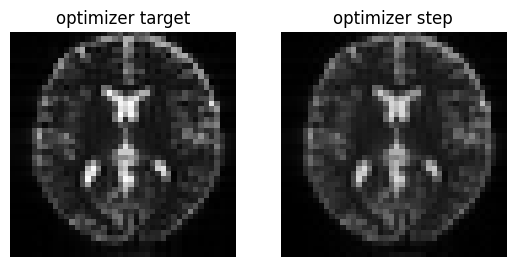

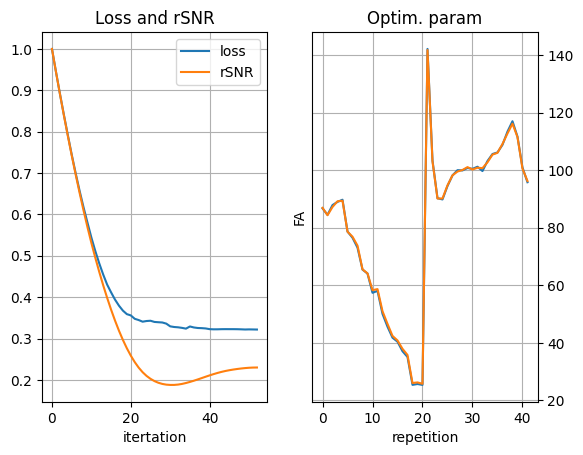

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
54 / 100: loss=0.04820748046040535, rSAR=0.22976523637771606, Ref_FA=[ 87.08374   84.343185  86.285934  89.386505  88.739136  78.833984
  76.990135  74.26378   65.76743   64.19968   59.023483  59.09979
  51.960445  47.543785  43.010117  41.280724  38.7787    36.4906
  26.746248  26.848492  26.225342 141.22887  102.76178   89.94414
  90.50252   94.82055   98.143715  99.081085 100.095314 101.09211
 100.15699  100.41897  101.356285 102.40327  105.001144 106.01151
 109.11668  112.24491  115.072754 111.16945  100.51647   96.38377 ]


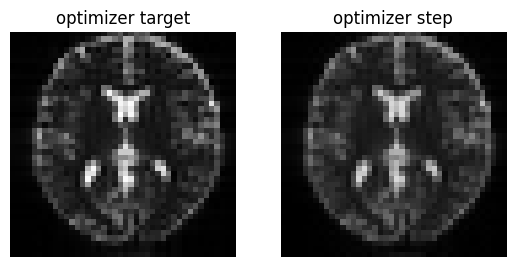

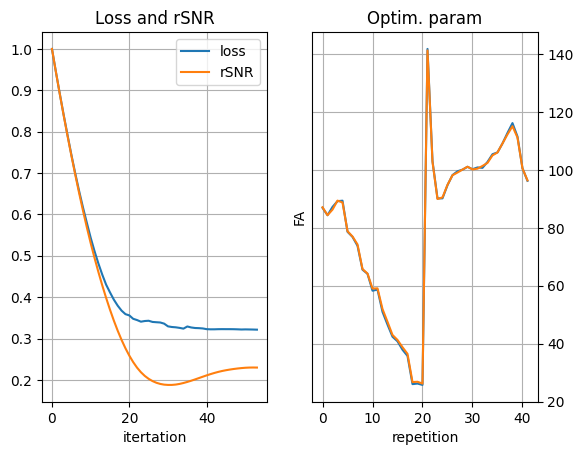

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
55 / 100: loss=0.04814491420984268, rSAR=0.22938787937164307, Ref_FA=[ 87.16163   84.41078   85.21276   89.41181   87.98021   79.24544
  76.90501   74.48249   66.11856   64.340416  59.584457  59.360626
  52.971504  48.469406  43.613842  41.781445  39.660927  37.215652
  27.511854  27.518915  26.75153  140.65002  102.49337   89.73217
  90.78436   94.91326   97.98556   98.76762   99.989845 100.92434
 100.150345 100.12362  101.422485 102.29349  104.43503  106.07536
 108.87513  111.81728  113.91189  110.5557   100.84057   96.419716]


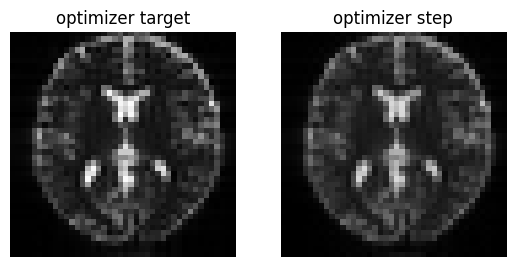

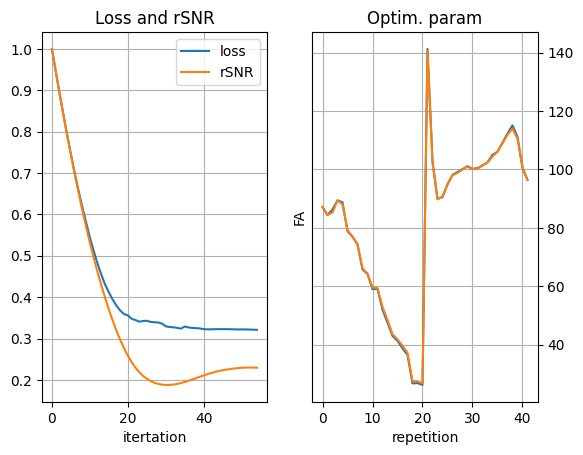

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
56 / 100: loss=0.048061810433864594, rSAR=0.22882771492004395, Ref_FA=[ 87.047485  84.48204   84.09163   89.14434   87.20962   79.78564
  76.66484   74.43978   66.571724  64.538826  59.971867  59.476467
  53.98325   49.340996  44.204586  42.314873  40.540886  37.933777
  28.314255  28.231283  27.32606  140.11467  102.18797   89.57457
  90.98044   95.03409   97.73979   98.59589   99.731834 100.64637
 100.11736  100.04161  100.910545 102.3657   103.81243  106.12695
 108.50535  111.39001  112.78093  109.69688  101.407196  96.464516]


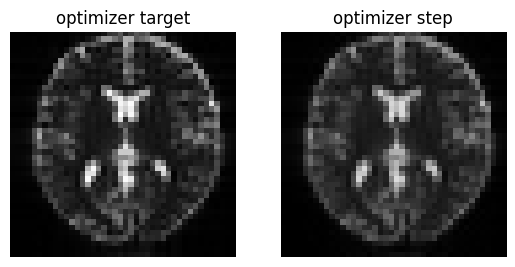

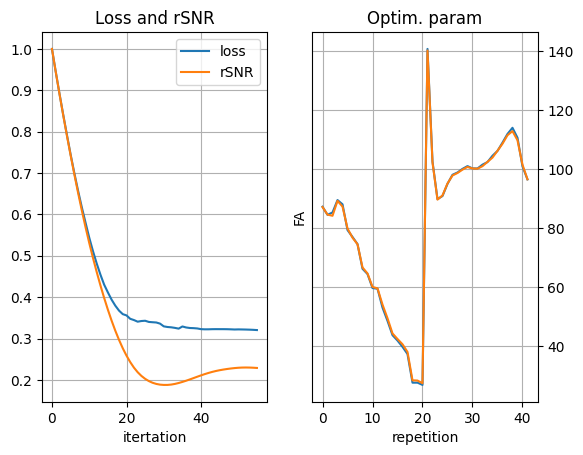

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
57 / 100: loss=0.04799805209040642, rSAR=0.22813411056995392, Ref_FA=[ 86.832184  84.25649   83.24576   88.30423   86.774925  80.33643
  76.2464    74.3025    67.15655   64.66385   60.223034  59.585236
  54.90871   50.113968  44.79619   42.925068  41.38911   38.64768
  29.138607  28.982155  27.932095 139.7952   101.66409   89.60868
  90.97261   95.1959    97.45313   98.46025   99.36481  100.26949
  99.9985   100.11396  100.007866 102.45351  103.25723  106.05232
 108.10754  110.85452  111.76613  108.72869  102.15338   96.54049 ]


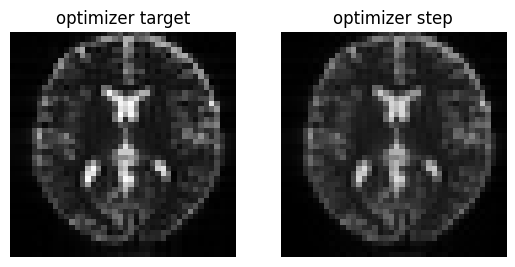

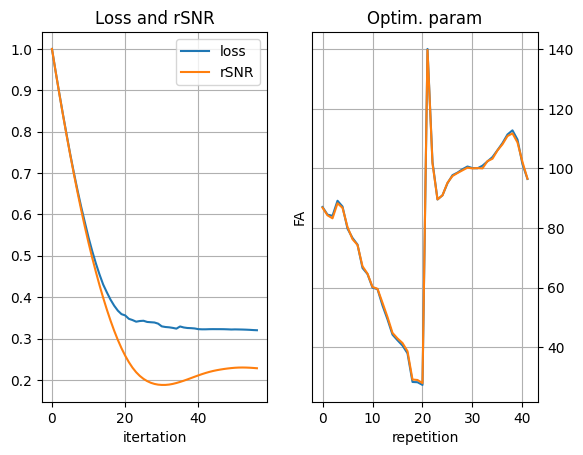

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
58 / 100: loss=0.047939710319042206, rSAR=0.2273181676864624, Ref_FA=[ 86.60168   83.723236  82.649925  86.981186  86.676636  80.82802
  75.71903   74.09928   67.812515  64.722786  60.357704  59.708492
  55.72251   50.77607   45.38225   43.5987    42.194557  39.347034
  29.973063  29.757784  28.56117  139.65852  100.986885  89.76648
  90.82267   95.27154   97.21285   98.29793   98.87018   99.85283
  99.8195   100.17973   99.039345 102.37223  102.89605  105.76235
 107.7668   110.19211  110.81153  107.82089  102.89618   96.62047 ]


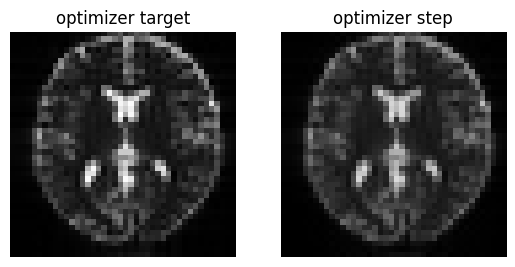

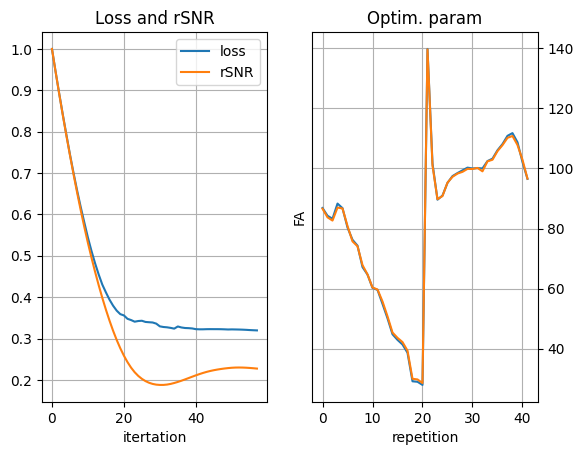

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
59 / 100: loss=0.04788997396826744, rSAR=0.22638191282749176, Ref_FA=[ 86.43323   82.927605  82.21659   85.363075  86.83782   81.19856
  75.16453   73.86456   68.464905  64.72824   60.399513  59.863045
  56.404034  51.3189    45.956715  44.319893  42.948143  40.02267
  30.806984  30.544382  29.205372 139.5761   100.30456   89.91357
  90.61739   95.16143   97.077225  98.05799   98.246414  99.42309
  99.64867  100.0559    98.31513  101.99342  102.76973  105.25504
 107.49946  109.430214 109.83276  107.14402  103.45374   96.68359 ]


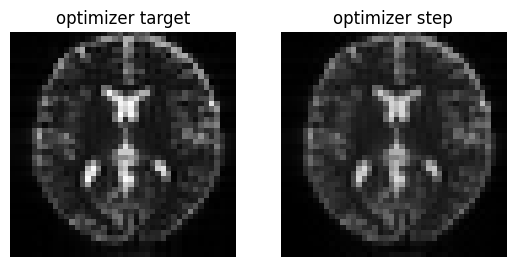

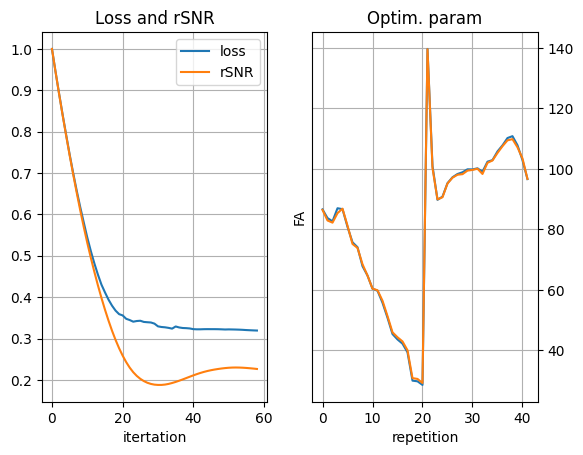

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
60 / 100: loss=0.04784772917628288, rSAR=0.22534415125846863, Ref_FA=[ 86.313446  81.95373   81.830124  83.68174   87.13391   81.40878
  74.6609    73.6341    69.03435   64.69845   60.37266   60.05946
  56.93953   51.738598  46.514137  45.072647  43.64252   40.667305
  31.6308    31.328798  29.857382 139.39424   99.79394   89.91829
  90.42047   94.88597   97.044334  97.730515  97.52837   98.98998
  99.535355  99.668495  97.95996  101.3376   102.79944  104.64337
 107.246635 108.628555 108.80112  106.77619  103.69588   96.77564 ]


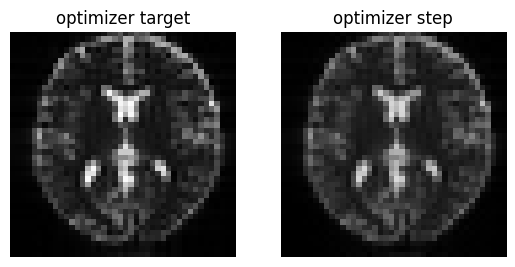

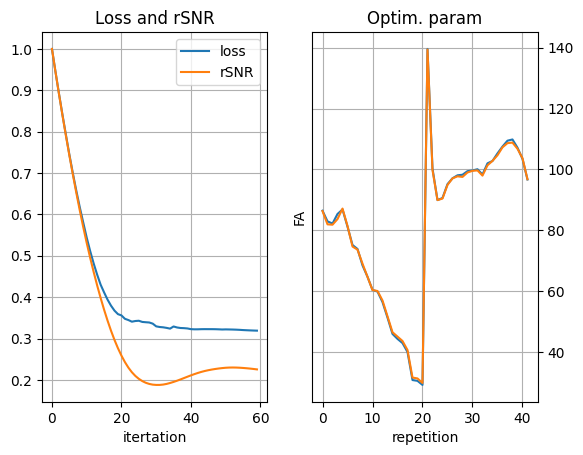

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
61 / 100: loss=0.047652535140514374, rSAR=0.22424745559692383, Ref_FA=[ 86.159515  80.9013    81.381096  82.16169   87.42711   81.450485
  74.26987   73.43807   69.44945   64.655334  60.298946  60.301006
  57.3232    52.03639   47.049183  45.841934  44.272335  41.27503
  32.435787  32.09923   30.51003  139.04398   99.563156  89.71813
  90.245415  94.573425  97.0618    97.340614  96.78164   98.55917
  99.46898   99.09301   97.86833  100.55893  102.82985  104.09618
 106.922905 107.84051  107.77519  106.66554  103.59854   96.97191 ]


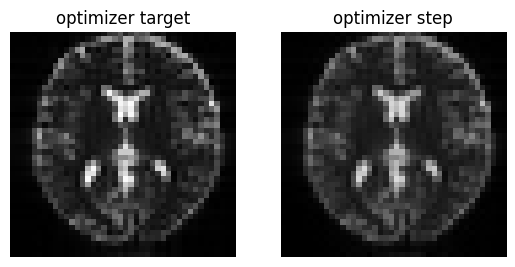

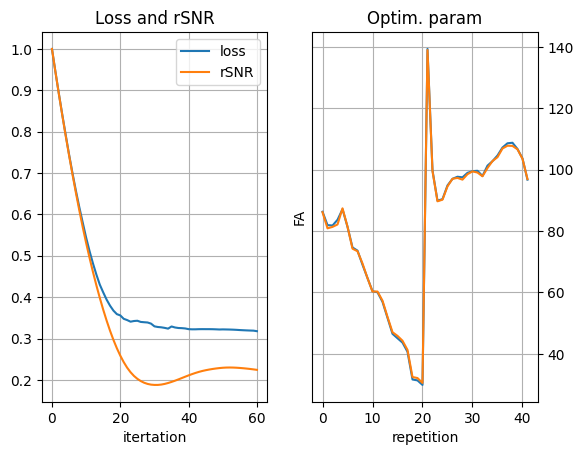

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
62 / 100: loss=0.04756632819771767, rSAR=0.2234451174736023, Ref_FA=[ 85.789825  79.87549   80.65642   81.08247   87.56098   81.039566
  74.2693    73.26463   69.4877    64.76106   60.154087  60.56022
  57.556705  52.291016  47.53227   46.601734  44.811695  41.847805
  33.200462  32.8376    31.1626   139.176     99.43633   90.02385
  89.927956  95.355095  97.42239   96.77046   96.47311   97.74867
  99.58617   98.580055  97.55045   99.88677  102.80765  103.63694
 106.49086  107.10127  106.81629  106.616516 103.27687   97.34877 ]


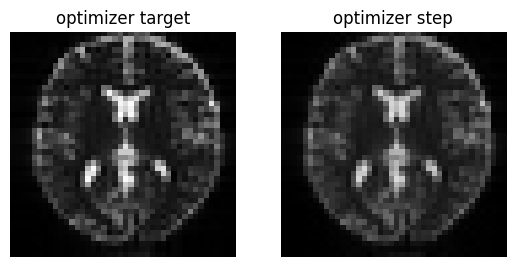

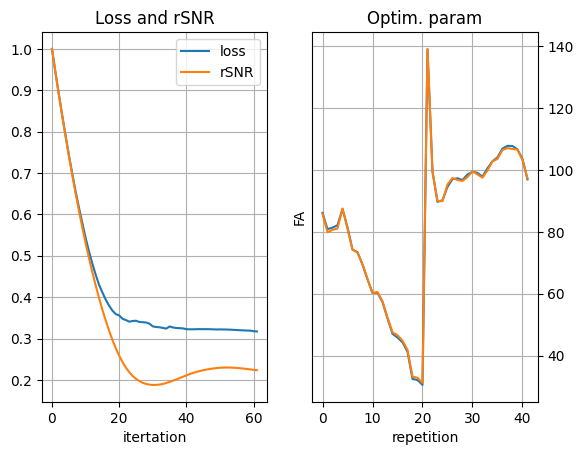

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
63 / 100: loss=0.04746433347463608, rSAR=0.22288694977760315, Ref_FA=[ 85.407166  78.93374   79.66584   80.48484   87.47695   80.27786
  74.6109    73.13297   69.172615  64.993935  59.950787  60.824974
  57.65012   52.510178  47.95933   47.33293   45.258785  42.376064
  33.91625   33.537167  31.807117 139.73721   99.45738   90.642
  89.68304   96.85759   98.12726   96.08959   96.42143   96.721825
  99.7082    98.18278   96.95197   99.371666 102.631004 103.317154
 105.9431   106.35806  105.96636  106.55174  102.91301   97.68508 ]


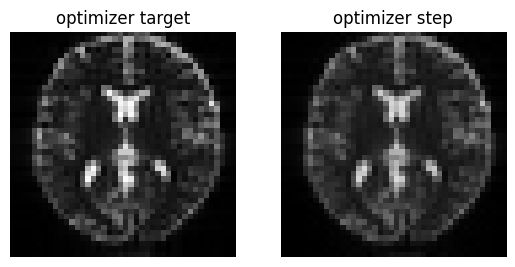

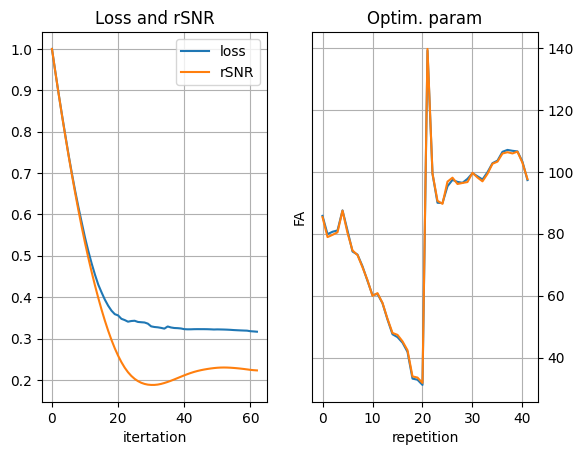

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
64 / 100: loss=0.04736695811152458, rSAR=0.22249820828437805, Ref_FA=[ 85.26221   78.12967   78.47489   80.28936   87.16406   79.30126
  75.1956    73.05128   68.56788   65.313484  59.698086  61.07746
  57.618195  52.70126   48.32489   48.018097  45.611893  42.84966
  34.575386  34.191837  32.435417 140.57915   99.728096  91.3042
  89.848305  98.59061   99.20711   95.434685  96.29576   95.72248
  99.62662   97.89145   96.14048   98.96862  102.25971  103.13827
 105.29634  105.542015 105.25329  106.4051   102.71076   97.7085  ]


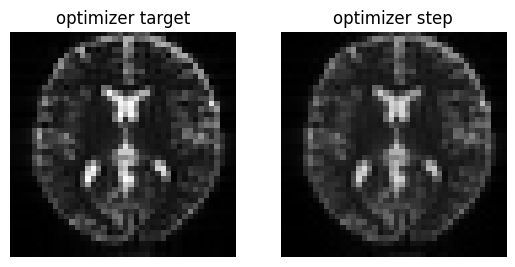

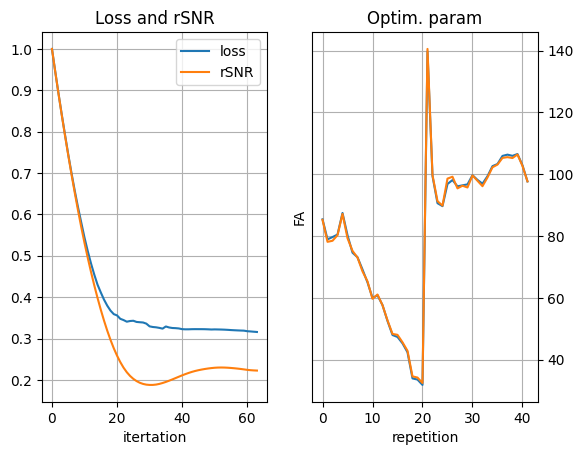

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
65 / 100: loss=0.047246307134628296, rSAR=0.22221577167510986, Ref_FA=[ 85.39331   77.50994   77.194176  80.33685   86.64225   78.2611
  75.900345  73.01485   67.76266   65.66772   59.40401   61.299614
  57.48086   52.867832  48.62549   48.644028  45.872375  43.259705
  35.172115  34.795853  33.039528 141.46912  100.351875  91.813286
  90.63515  100.218216 100.61784   94.996666  95.80733   94.95462
  99.22951   97.66548   95.273224  98.570114 101.75522  103.065994
 104.568115 104.64058  104.70619  106.12766  102.74228   97.37626 ]


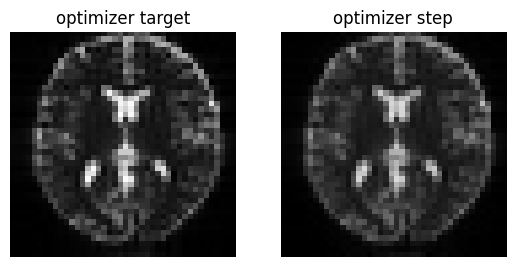

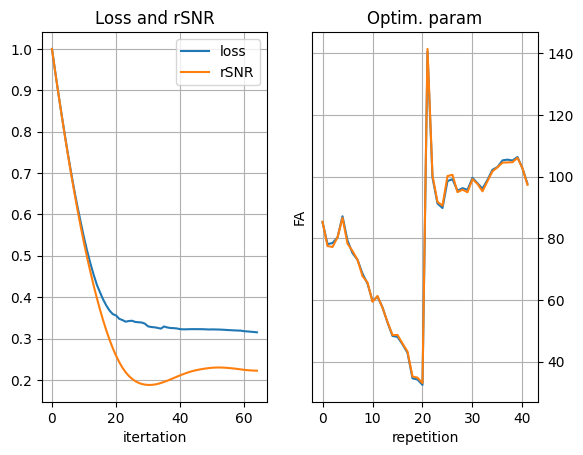

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
66 / 100: loss=0.04822824150323868, rSAR=0.22201986610889435, Ref_FA=[ 85.55563   77.10251   75.953285  80.43785   85.94462   77.30248
  76.59907   73.00848   66.856064  66.001625  59.07762   61.475388
  57.261353  53.008827  48.859867  49.202744  46.044174  43.600403
  35.702953  35.344208  33.612015 142.19145  101.332565  92.177185
  91.94909  101.769    102.198944  94.92391   94.9261    94.43511
  98.586136  97.47262   94.48583   98.09189  101.24693  103.04806
 103.76483  103.73946  104.33226  105.70852  102.90144   96.94436 ]


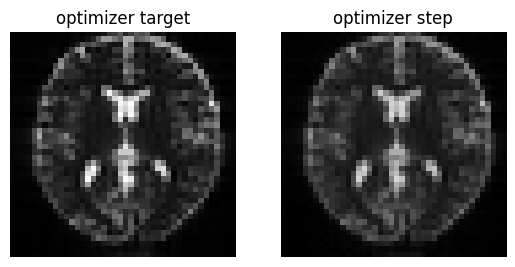

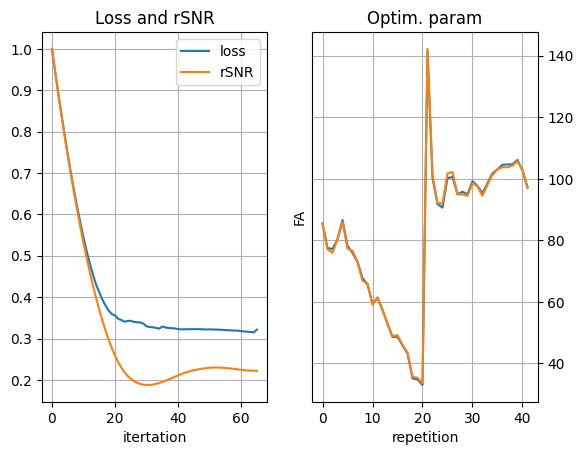

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
67 / 100: loss=0.0479956679046154, rSAR=0.22163307666778564, Ref_FA=[ 85.83258   77.36258   74.592964  80.832344  84.94092   76.7383
  77.136185  72.9614    66.0924    66.19654   58.754444  61.630405
  56.94818   53.14023   49.09728   49.604206  46.173927  43.859585
  36.184605  35.848198  34.156162 141.97202  102.96132   91.536156
  93.9404   102.36579  103.324936  95.76427   92.72083   94.9451
  97.62218   96.944466  94.37807   97.48457  100.70354  103.07649
 103.09739  102.79928  104.08545  105.22756  103.050095  96.38498 ]


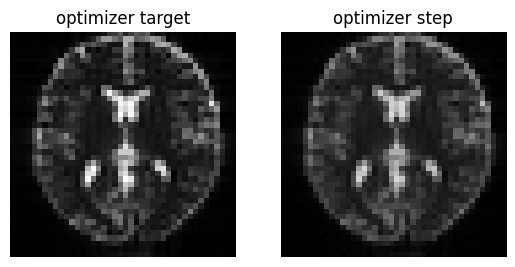

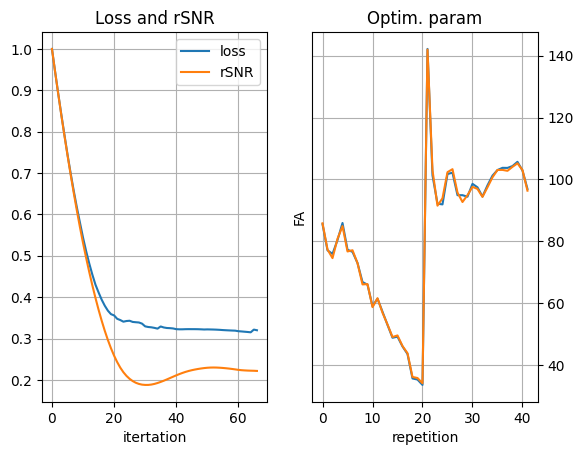

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
68 / 100: loss=0.04806457459926605, rSAR=0.22125546634197235, Ref_FA=[ 85.752335  78.087326  73.33272   81.2343    83.74429   76.60427
  77.44229   72.85881   65.54263   66.22191   58.442287  61.761154
  56.568073  53.252346  49.343117  49.861416  46.260468  44.038967
  36.614082  36.305847  34.66696  141.39775  104.67986   90.691414
  95.90056  102.8379   104.02139   96.90217   90.44122   95.57175
  96.77741   96.30901   94.550125  96.87433  100.27171  103.06683
 102.54506  102.032524 103.91966  104.71586  102.989494  96.16971 ]


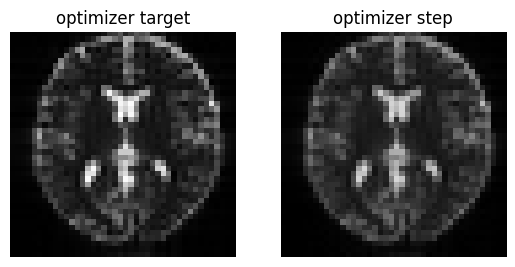

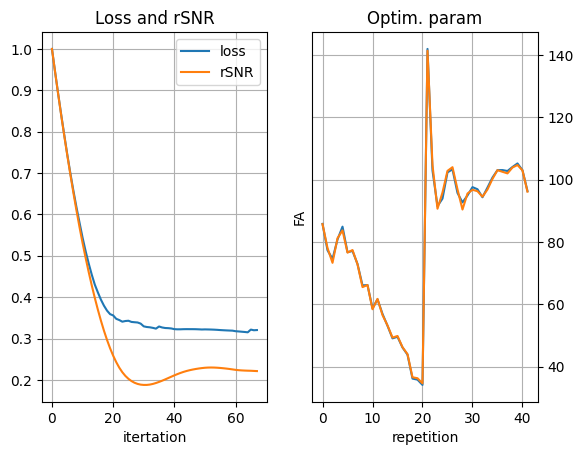

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
69 / 100: loss=0.04824511334300041, rSAR=0.22094227373600006, Ref_FA=[ 85.51021   79.051575  72.40162   81.381065  82.532104  76.87077
  77.49851   72.712036  65.2441    66.06652   58.14846   61.86931
  56.146877  53.33671   49.60043   49.986626  46.302723  44.141262
  36.989723  36.715446  35.137356 141.18817  105.78411   90.31802
  97.17435  103.61458  104.43585   97.54437   89.33713   95.407
  96.35173   95.73613   94.581856  96.354095  99.984055 102.89363
 102.17529  101.43955  103.69917  104.30433  102.73191   96.1415  ]


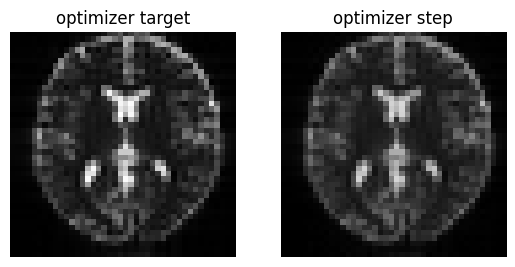

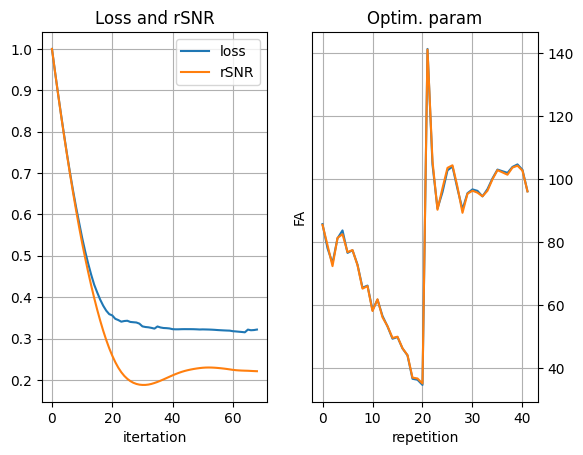

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
70 / 100: loss=0.048133041709661484, rSAR=0.2206616997718811, Ref_FA=[ 85.45791   80.0263    71.95465   81.12044   81.48672   77.43709
  77.32832   72.55598   65.19159   65.74021   57.876995  61.949547
  55.71042   53.391315  49.86574   49.992176  46.302017  44.17135
  37.308857  37.076237  35.561356 141.79889  105.81061   90.789085
  97.443184 104.74133  104.75854   97.18948   89.84836   94.16416
  96.320595  95.36083   94.214554  95.977394  99.800896 102.497116
 102.03262  100.95614  103.314    104.1127   102.369385  95.98494 ]


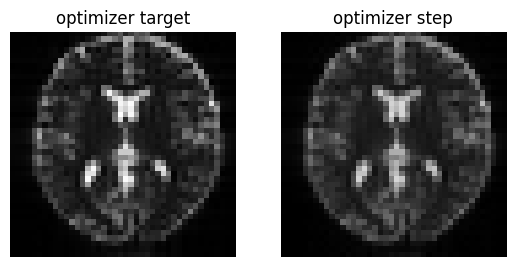

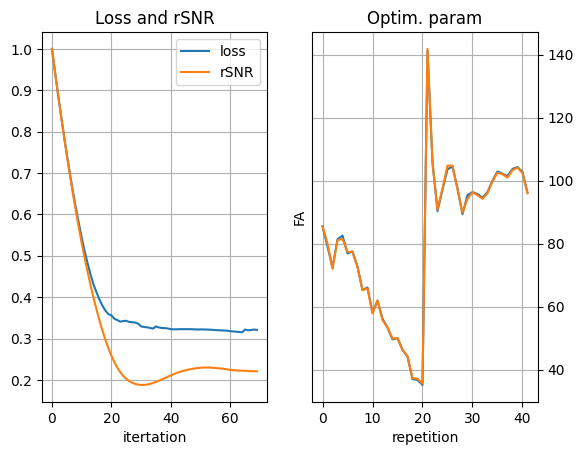

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
71 / 100: loss=0.048075128346681595, rSAR=0.2204081416130066, Ref_FA=[ 85.40384   80.78315   72.01499   80.4584    80.71818   78.14706
  76.98163   72.43128   65.340614  65.27023   57.62834   61.982452
  55.28264   53.424053  50.12579   49.89002   46.26553   44.13484
  37.56889   37.388096  35.93653  142.85587  105.128525  91.84559
  97.073845 105.92513  105.05812   96.22885   91.19214   92.56051
  96.29859   95.25211   93.58752   95.75824   99.66273  102.04621
 101.99175  100.64379  102.91471  104.00377  101.956924  95.856346]


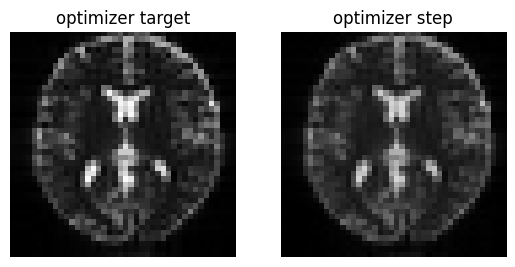

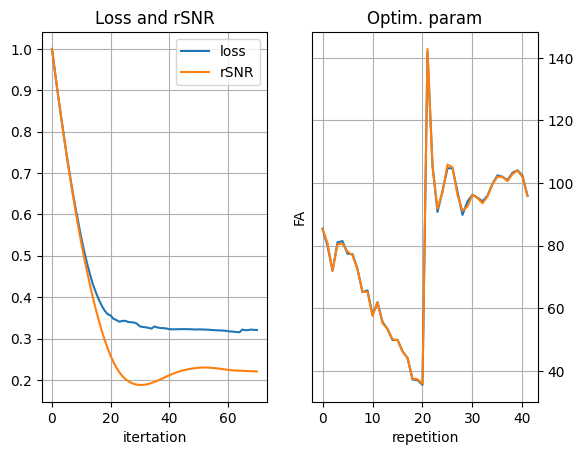

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
72 / 100: loss=0.04811684042215347, rSAR=0.2201383411884308, Ref_FA=[ 85.10397   81.022995  72.75407   79.23977   80.30753   78.922356
  76.50434   72.32654   65.64439   64.73493   57.417034  61.899826
  54.926834  53.416275  50.339897  49.744232  46.202847  44.036922
  37.764957  37.648335  36.260483 143.73228  104.32236   92.957245
  96.64012  106.745834 105.27022   95.34067   92.34149   91.44185
  95.94779   95.300804  93.02162   95.63354   99.52123  101.693634
 101.90063  100.54079  102.691986 103.88054  101.631485  95.99457 ]


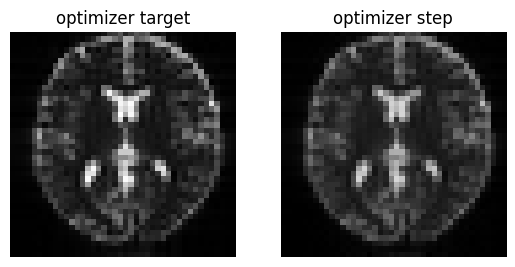

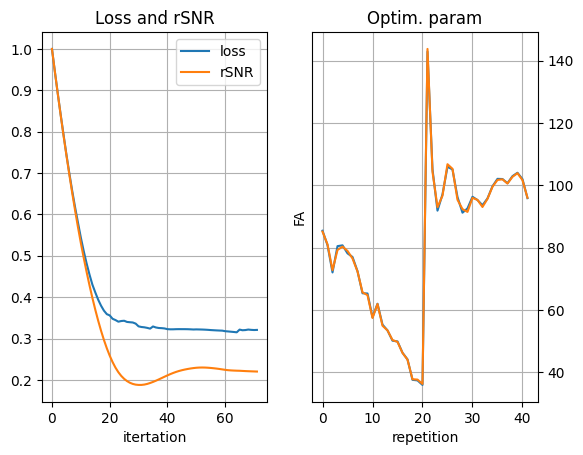

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
73 / 100: loss=0.04813207685947418, rSAR=0.2197479009628296, Ref_FA=[ 84.81781   80.76338   73.964745  77.755066  80.24632   79.59975
  75.99668   72.266815  66.04032   64.1677    57.247643  61.69641
  54.65219   53.377575  50.499218  49.559452  46.122257  43.8814
  37.897415  37.855022  36.53531  143.95374  103.83729   93.62111
  96.57024  106.87747  105.3079    94.98524   92.55834   91.25761
  95.1817    95.257774  92.81874   95.526054  99.29226  101.48411
 101.77123  100.54608  102.60336  103.80856  101.450485  96.145454]


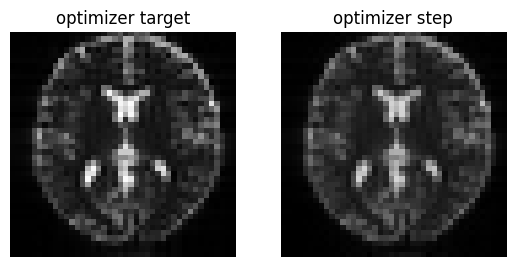

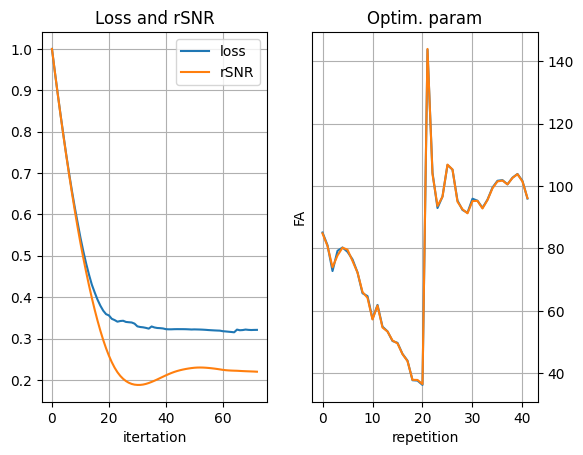

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
74 / 100: loss=0.048013098537921906, rSAR=0.21919874846935272, Ref_FA=[ 84.79141   80.13168   75.37537   76.36371   80.46775   80.04955
  75.556564  72.26533   66.46684   63.6095    57.11787   61.37984
  54.46522   53.310314  50.59973   49.3403    46.02649   43.676086
  37.9691    38.00596   36.76264  143.36166  103.87238   93.58714
  97.00436  106.30351  105.07208   95.29616   91.771454  91.86861
  94.21075   94.91703   93.065704  95.41306   98.93267  101.381996
 101.6712   100.55554  102.56314  103.87915  101.44421   96.06144 ]


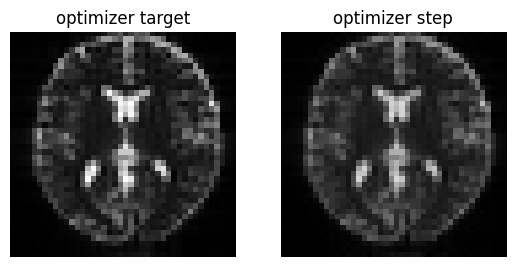

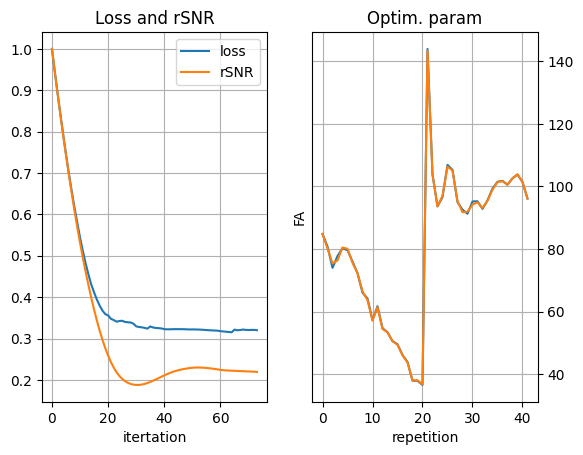

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
75 / 100: loss=0.04796572029590607, rSAR=0.21859918534755707, Ref_FA=[ 84.883095  79.31148   76.70259   75.41551   80.85754   80.19756
  75.25798   72.32394   66.867004  63.106155  57.018658  60.97136
  54.367733  53.20907   50.643227  49.094337  45.916058  43.43346
  37.984028  38.10175   36.942844 142.2211   104.26952   93.079094
  97.68769  105.39429  104.54097   96.00218   90.606445  92.69401
  93.41079   94.343346  93.5191    95.38318   98.497635 101.32216
 101.64621  100.58836  102.5581   104.09074  101.53571   95.86526 ]


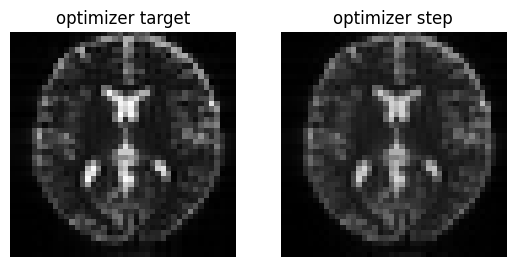

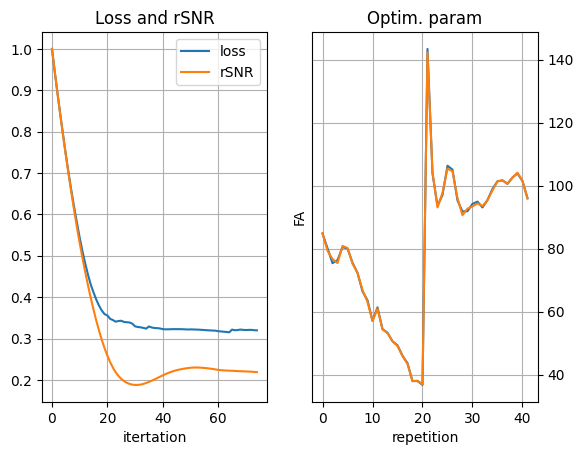

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
76 / 100: loss=0.04845326021313667, rSAR=0.21807144582271576, Ref_FA=[ 84.894585  78.522835  77.711914  75.14802   81.30857   80.03532
  75.143074  72.43446   67.19878   62.70257   56.937424  60.50368
  54.355515  53.067554  50.63434   48.831814  45.792236  43.166702
  37.947422  38.14544   37.0751   141.01628  104.65587   92.52045
  98.220345 104.5514   103.796265  96.64122   89.83093   93.140205
  93.01774   93.75088   93.851776  95.50578   98.08363  101.23922
 101.70782  100.69293  102.60337  104.399155 101.64763   95.73751 ]


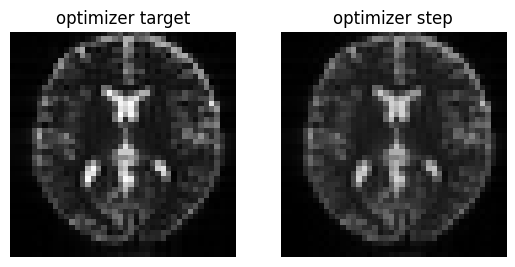

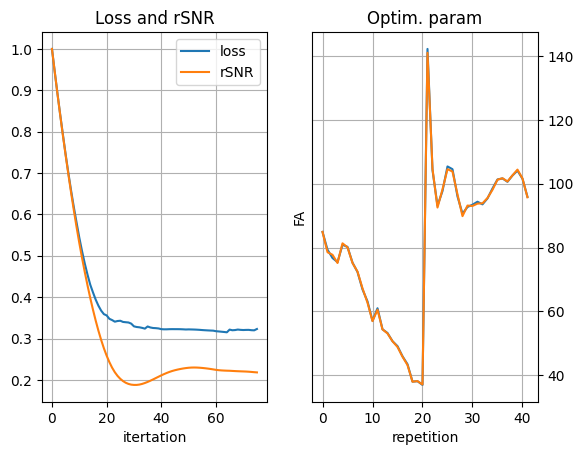

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
77 / 100: loss=0.04840800538659096, rSAR=0.217683345079422, Ref_FA=[ 84.5034    78.17562   78.323975  75.646576  81.94041   79.422646
  75.251144  72.73966   67.38702   62.546894  56.79587   59.96847
  54.43512   52.94814   50.58284   48.55718   45.655464  42.900185
  37.87681   38.1246    37.16436  140.18     104.42203   92.53946
  98.137726 103.960236 103.0323    96.74751   89.906685  92.92186
  92.96791   93.35095   93.916374  95.58791   98.00229  100.893616
 101.88026  100.89477  102.842926 104.86083  101.384155  96.05431 ]


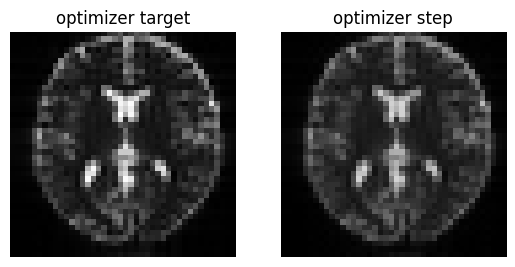

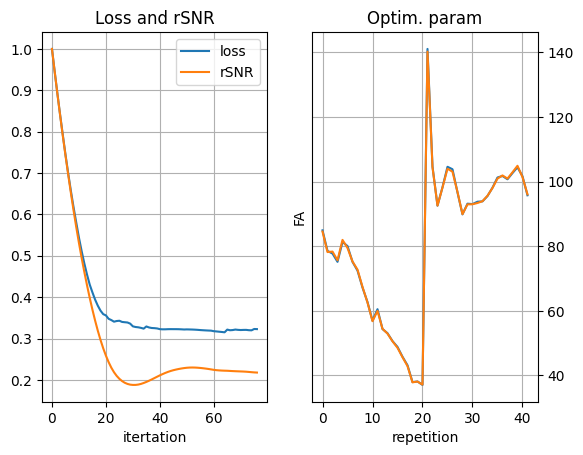

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
78 / 100: loss=0.04824943467974663, rSAR=0.21737846732139587, Ref_FA=[ 84.0598    78.305595  78.51879   76.820145  82.65044   78.52363
  75.521774  73.19128   67.44006   62.634712  56.602245  59.407635
  54.5755    52.84731   50.490074  48.277477  45.510693  42.640938
  37.774532  38.044125  37.211227 139.93883  103.46687   93.069984
  97.53839  103.37679  102.397095  96.17312   90.77959   92.101204
  93.047516  93.193794  93.71007   95.51538   98.25152  100.2803
 102.09374  101.153435 103.186165 105.438416 100.97984   96.43646 ]


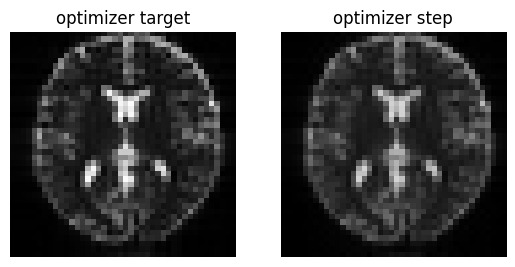

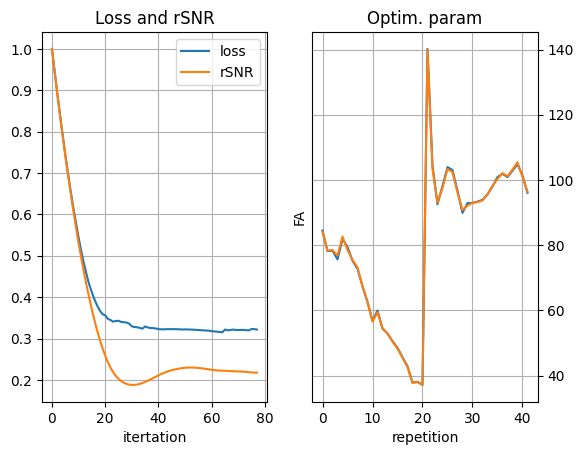

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
79 / 100: loss=0.04817512258887291, rSAR=0.2170657217502594, Ref_FA=[ 83.85323   78.804405  78.39201   78.46445   83.29854   77.567245
  75.865295  73.71549   67.38825   62.93835   56.378857  58.853592
  54.742588  52.763844  50.350826  48.002613  45.361015  42.39499
  37.642323  37.90873   37.21752  140.03323  102.120316  93.70149
  96.79193  102.48916  101.86243   95.243065  91.883354  91.140175
  92.962036  93.20665   93.38607   95.25072   98.67538   99.56214
 102.188835 101.46141  103.606255 106.00962  100.734436  96.53813 ]


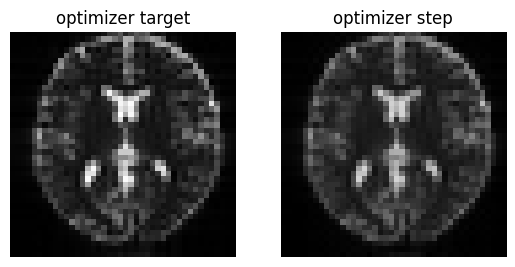

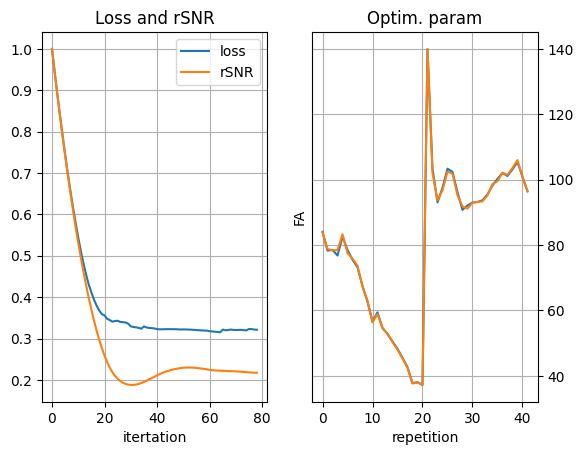

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
80 / 100: loss=0.04818560183048248, rSAR=0.21667374670505524, Ref_FA=[ 83.925285  79.52018   78.12266   80.310196  83.772964  76.783554
  76.19296   74.237434  67.27756   63.41261   56.154408  58.33444
  54.908024  52.69597   50.16075   47.74455   45.21065   42.16769
  37.483524  37.72446   37.18609  139.94348  100.92234   93.96397
  96.22391  101.266075 101.19811   94.51814   92.52583   90.55787
  92.5672    93.23457   93.112045  94.90633   98.99864   99.0086
 102.00671  101.82222  104.168884 106.44393  100.77365   96.30508 ]


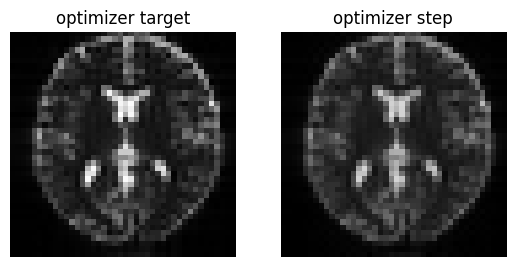

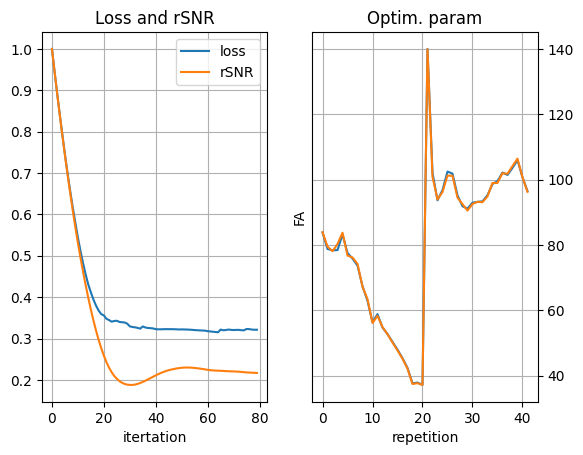

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
81 / 100: loss=0.048443712294101715, rSAR=0.21620914340019226, Ref_FA=[ 84.050354  80.299194  77.914925  82.06717   84.02991   76.346985
  76.437454  74.69334   67.15907   64.00173   55.956116  57.880924
  55.050053  52.638786  49.922455  47.51517   45.066177  41.96542
  37.30341   37.498795  37.120506 139.31061  100.25714   93.66769
  95.88738   99.9755   100.197     94.3479    92.41704   90.5552
  91.98224   93.14284   92.95209   94.680664  99.01098   98.799385
 101.52119  102.2371   104.95611  106.702774 100.962494  96.00793 ]


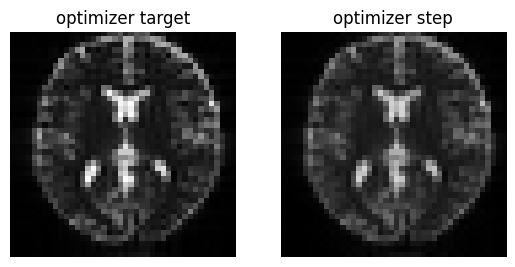

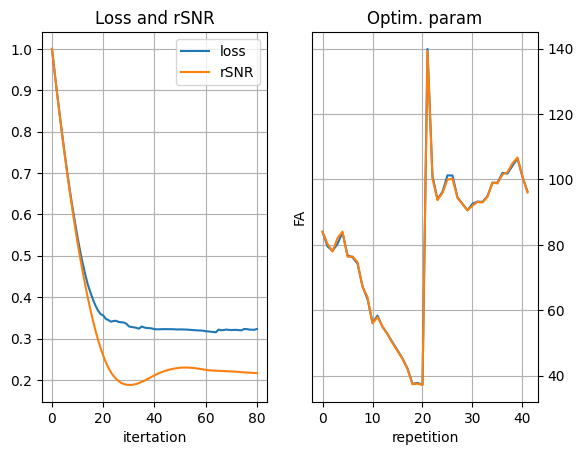

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
82 / 100: loss=0.04834669455885887, rSAR=0.21635288000106812, Ref_FA=[ 84.28085   80.789024  77.83119   83.608604  84.077896  76.397934
  76.572235  74.86904   67.03186   64.69941   55.848137  57.605316
  55.246807  52.56079   49.579865  47.31009   44.92505   41.78564
  37.095554  37.22886   37.045166 138.45251  100.556305  92.83392
  95.87444   99.31476   98.96446   94.84795   92.04519   91.12105
  91.78744   93.09705   93.0121    95.129555  98.637856  99.22287
 101.208206 102.75937  106.1682   106.8656   101.568665  95.582085]


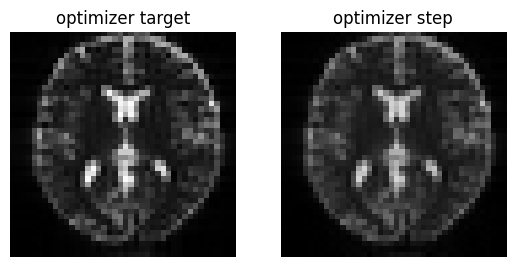

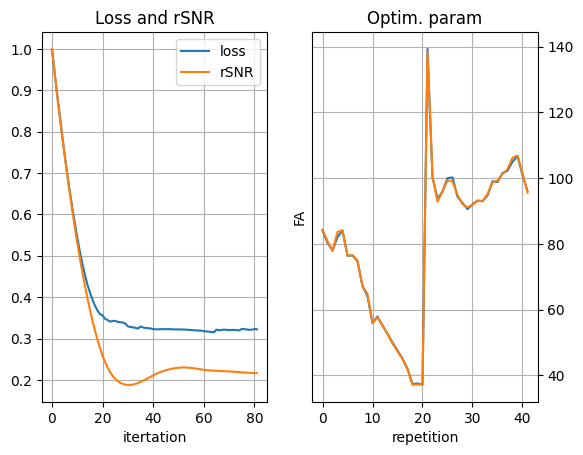

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
83 / 100: loss=0.04829408973455429, rSAR=0.21711020171642303, Ref_FA=[ 84.347404  80.92392   77.968376  84.72807   84.01583   76.89124
  76.591995  74.759056  66.94903   65.43043   55.840805  57.519073
  55.470806  52.45982   49.15774   47.1309    44.793423  41.631393
  36.86622   36.92532   36.95946  137.73997  101.39963   91.85813
  95.99893   99.14298   97.856575  95.59119   91.78997   92.002594
  92.04861   93.180176  93.26995   96.05041   98.21046  100.007965
 101.137825 103.499054 107.60957  107.10086  102.284225  95.34077 ]


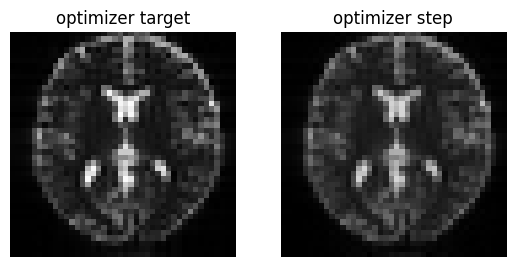

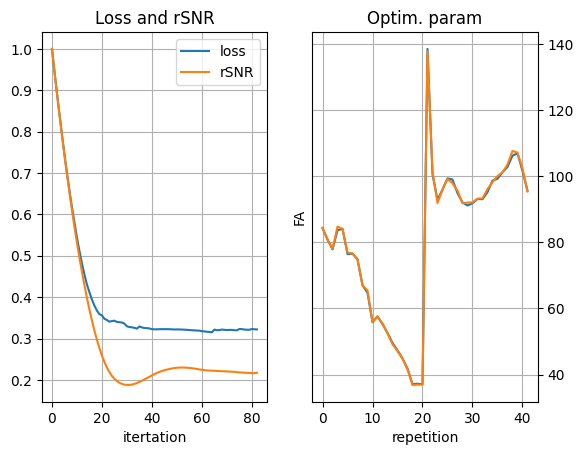

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
84 / 100: loss=0.04828084260225296, rSAR=0.2184276431798935, Ref_FA=[ 84.39476   80.75863   78.34756   85.298805  83.97645   77.713745
  76.512794  74.39419   66.94792   66.11909   55.937874  57.62301
  55.697628  52.335136  48.680714  46.97616   44.67207   41.503605
  36.620926  36.598522  36.861736 137.67831  102.250694  91.149796
  96.033745  99.21053   97.25967   96.04244   92.00551   92.94756
  92.70815   93.41638   93.75175   97.13826   98.08644  100.746826
 101.51141  104.4052   108.99832  107.66516  102.9069    95.19663 ]


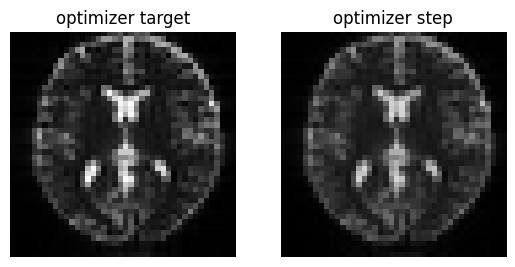

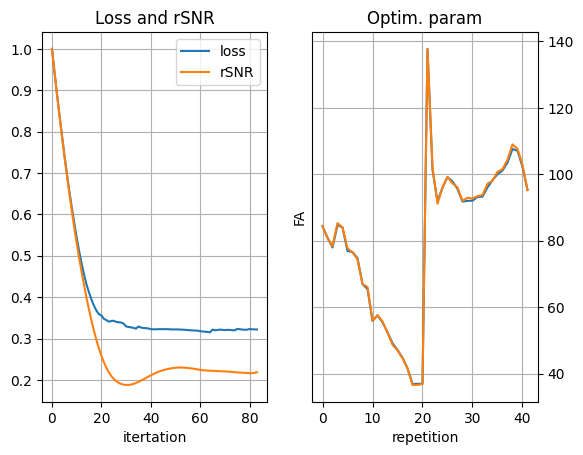

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
85 / 100: loss=0.0481441468000412, rSAR=0.22019800543785095, Ref_FA=[ 84.63015   80.45001   78.918     85.2947    84.07359   78.71412
  76.36217   73.84016   67.03636   66.701004  56.137363  57.90599
  55.90909   52.189556  48.16983   46.845276  44.55809   41.400387
  36.365685  36.257812  36.751186 138.55922  102.69631   90.989006
  95.81971   99.29987   97.392975  95.86665   92.84277   93.81075
  93.634834  93.82051   94.489876  98.10499   98.528244 101.107956
 102.452805 105.40512  110.09112  108.7375   103.3042    94.989746]


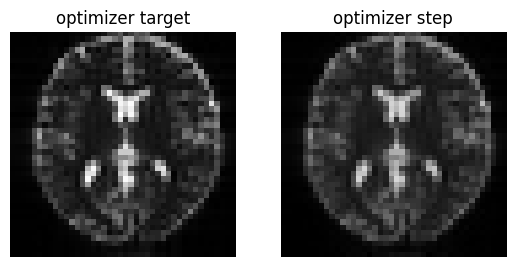

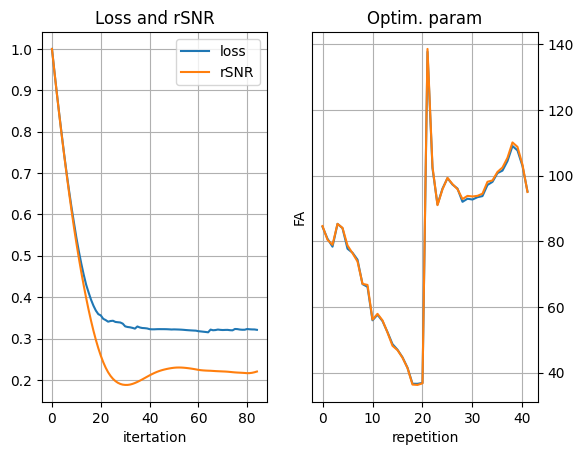

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
86 / 100: loss=0.04815750941634178, rSAR=0.2223321497440338, Ref_FA=[ 84.814064  80.1887    79.57213   84.78434   84.34848   79.72939
  76.16614   73.18611   67.186935  67.129326  56.434017  58.34403
  56.093365  52.02997   47.641582  46.742092  44.446766  41.31777
  36.107533  35.91093   36.629425 140.09969  102.81891   91.31866
  95.42958   99.39189   98.09137   95.33362   94.06298   94.701225
  94.67728   94.487656  95.41693   98.90727   99.4777   101.24385
 103.699814 106.583275 110.937294 110.15277  103.453445  94.91608 ]


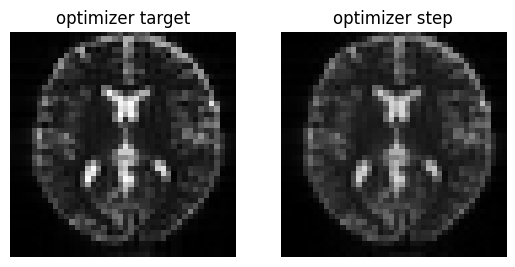

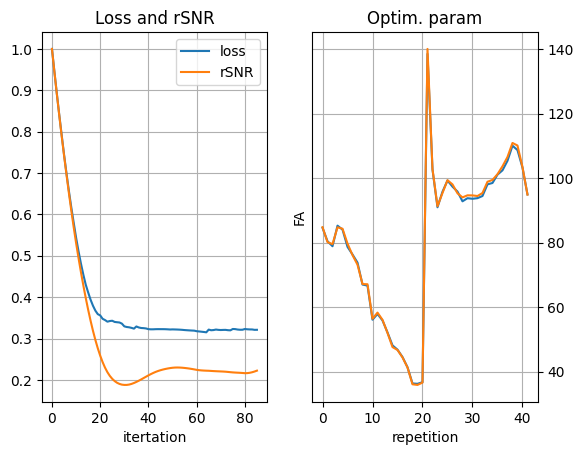

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
87 / 100: loss=0.048142414540052414, rSAR=0.22426672279834747, Ref_FA=[ 84.77542   80.10826   80.16006   83.90273   84.785385  80.6792
  75.86044   72.3344    67.724174  67.35344   56.80779   59.136997
  56.074577  51.821373  47.244568  46.622185  44.364483  41.239075
  35.85773   35.579014  36.51119  141.65637  102.76625   91.78736
  94.919174  99.23888   98.93313   94.73553   95.133354  95.60702
  95.564316  95.22516   96.271194  99.4838   100.52382  101.337135
 104.72273  107.824776 111.50452  111.42923  103.49835   95.04203 ]


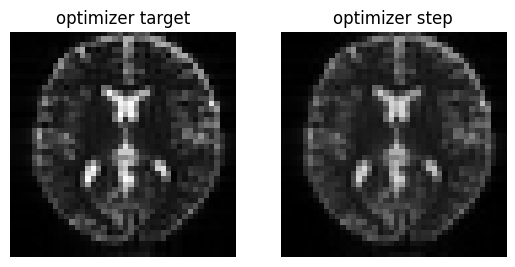

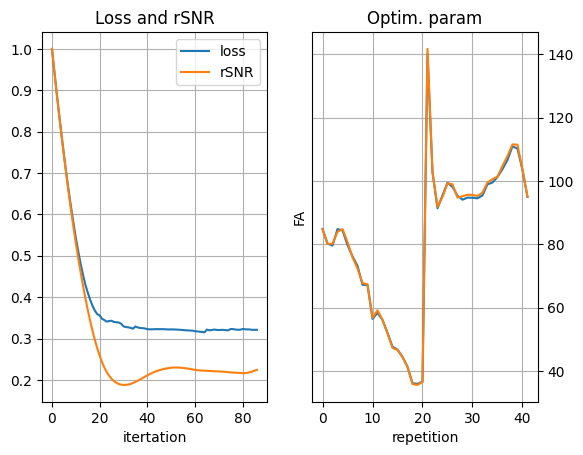

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
88 / 100: loss=0.048193324357271194, rSAR=0.22590774297714233, Ref_FA=[ 84.630226  80.24657   80.58008   82.906     85.291466  81.439835
  75.50156   71.42972   68.51026   67.39658   57.253216  60.19048
  55.890316  51.57143   46.972916  46.483776  44.299767  41.165916
  35.617218  35.264603  36.397907 142.74812  102.89013   92.09421
  94.420815  99.05106   99.49805   94.5356    95.747215  96.57438
  96.33278   95.963356  96.967926  99.97869  101.40728  101.57694
 105.45456  108.97553  111.980446 112.35481  103.61006   95.23774 ]


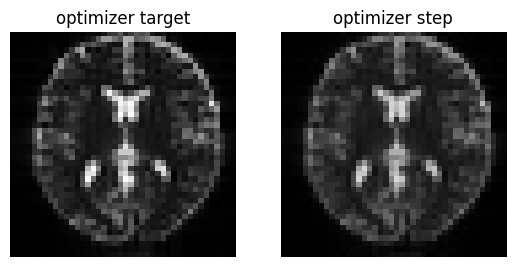

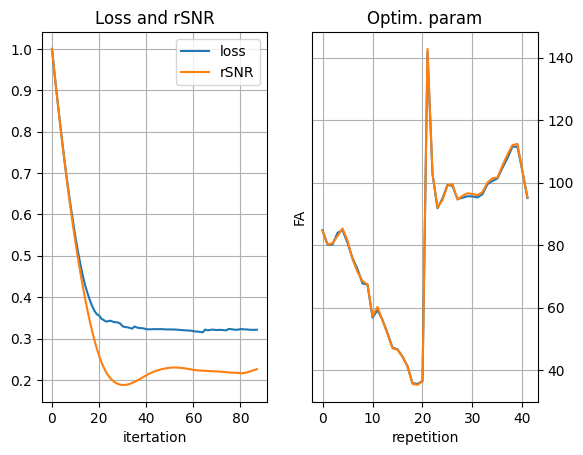

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
89 / 100: loss=0.04819768667221069, rSAR=0.22715549170970917, Ref_FA=[ 84.67354   80.587524  80.764465  82.04258   85.76296   81.922615
  75.14942   70.610596  69.39555   67.30181   57.762943  61.39796
  55.585224  51.28971   46.818676  46.323036  44.2415    41.09903
  35.388023  34.969406  36.29076  143.11667  103.36481   92.023964
  94.0186    98.92172   99.524864  94.92753   95.804794  97.50248
  97.08539   96.57006   97.45336  100.484634 101.92835  102.025406
 105.94788  109.83103  112.47811  112.821625 103.94825   95.22598 ]


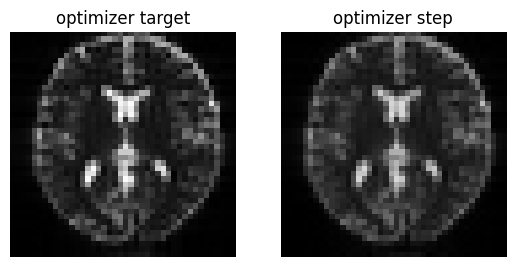

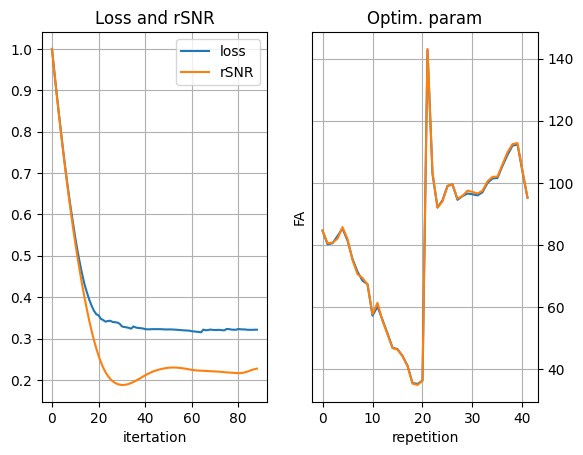

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
90 / 100: loss=0.048162464052438736, rSAR=0.22799986600875854, Ref_FA=[ 84.97132   81.06777   80.69202   81.50892   86.090904  82.08214
  74.85694   69.98462   70.24447   67.11594   58.32943   62.651203
  55.204456  50.989216  46.772114  46.1394    44.183117  41.03697
  35.174522  34.695206  36.190163 142.867    104.096565  91.61433
  93.72162   98.7793    99.10852   95.72773   95.51421   98.2209
  97.891815  97.02217   97.70462  101.00518  102.085846 102.63414
 106.28194  110.3139   113.00817  112.869576 104.4648    94.98229 ]


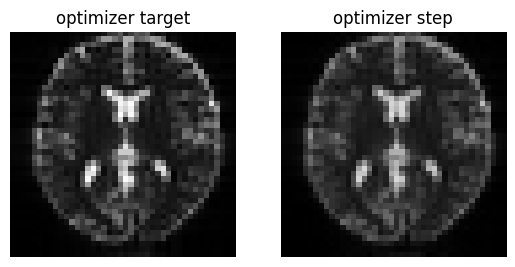

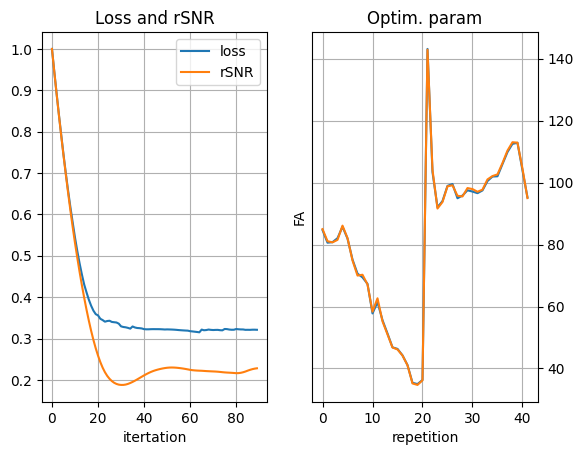

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
91 / 100: loss=0.04812243580818176, rSAR=0.22850646078586578, Ref_FA=[ 85.3338    81.607124  80.39519   81.40711   86.18742   81.919716
  74.659386  69.617226  70.950745  66.885254  58.94332   63.849377
  54.7896    50.687695  46.821545  45.93715   44.12287   40.977135
  34.98198   34.44491   36.09565  142.36154  104.793915  91.11557
  93.46071   98.46878   98.582924  96.534996  95.223656  98.625946
  98.69599   97.42876   97.75266  101.442825 102.06043  103.29197
 106.49742  110.51516  113.472176 112.665695 104.91575   94.74941 ]


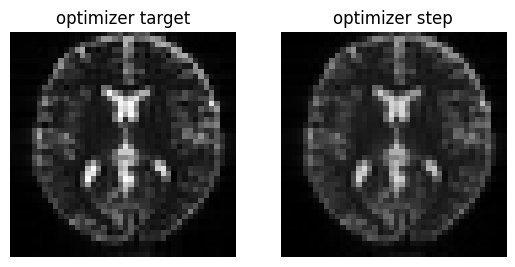

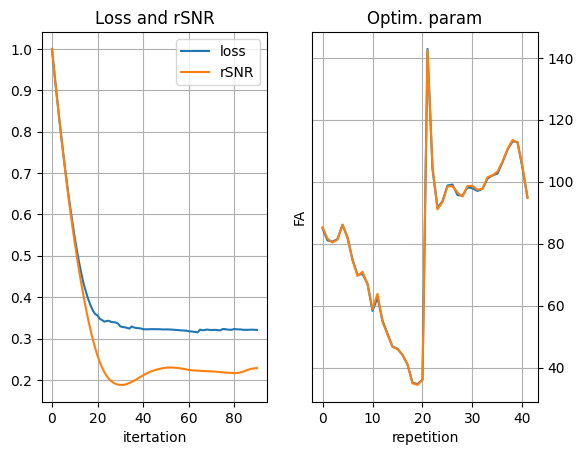

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
92 / 100: loss=0.04813428968191147, rSAR=0.2287716120481491, Ref_FA=[ 85.60298   82.01494   80.01125   81.77674   86.01268   81.2823
  74.75533   69.68843   71.18184   66.59748   59.609467  64.67853
  54.44247   50.487503  46.93482   45.650974  44.193768  40.94272
  34.805187  34.21312   35.9912   141.97868  105.1247    90.94932
  92.930405  98.15698   98.19662   97.02971   95.174286  98.75883
  99.418945  97.854744  97.74419  101.66992  102.09029  103.85044
 106.68164  110.621994 113.59574  112.65093  104.85116   94.811806]


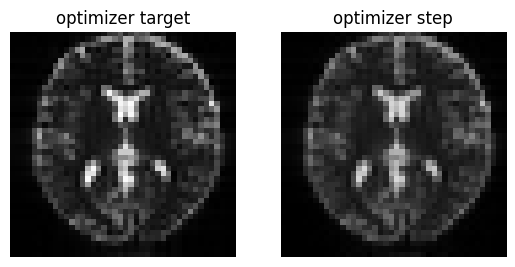

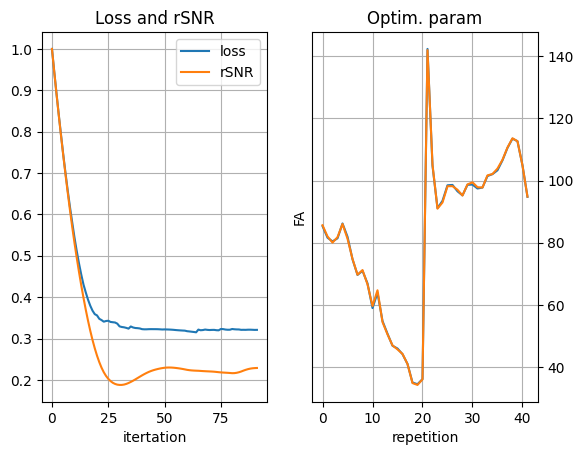

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
93 / 100: loss=0.04807884991168976, rSAR=0.22883285582065582, Ref_FA=[ 85.756546  82.24083   79.64773   82.46878   85.59657   80.3004
  75.07518   70.134766  70.97358   66.313576  60.289883  65.11488
  54.185726  50.39296   47.10268   45.296375  44.38328   40.930378
  34.64727   34.00249   35.87776  141.92036  104.97182   91.14904
  92.19715   97.66447   98.11975   97.063484  95.416664  98.704025
  99.92557   98.34847   97.756195 101.5916   102.29423  104.23442
 106.850624 110.65873  113.416374 112.78781  104.35136   95.16332 ]


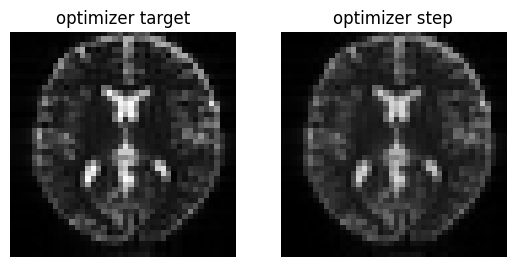

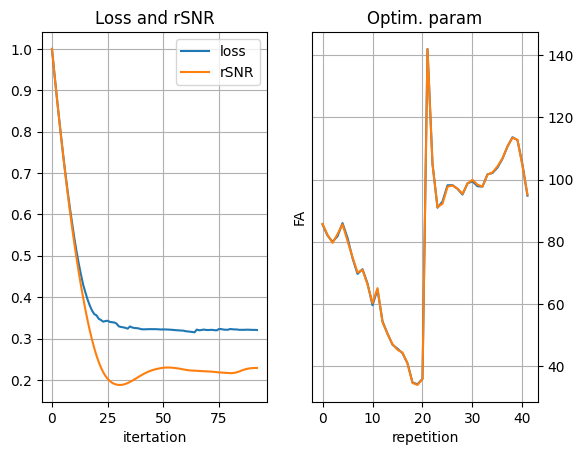

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
94 / 100: loss=0.04802285134792328, rSAR=0.22870291769504547, Ref_FA=[ 85.83095   82.25529   79.4079    83.24253   85.02903   79.131935
  75.50853   70.85016   70.40957   66.0795    60.935707  65.16067
  54.03128   50.40222   47.314156  44.889214  44.6725    40.936478
  34.510315  33.814415  35.75753  142.12657  104.45562   91.541695
  91.41522   96.937805  98.28641   96.76769   95.810455  98.57859
 100.16657   98.88071   97.825806 101.22243  102.65351  104.45727
 106.99578  110.586754 113.09112  112.88221  103.688515  95.67941 ]


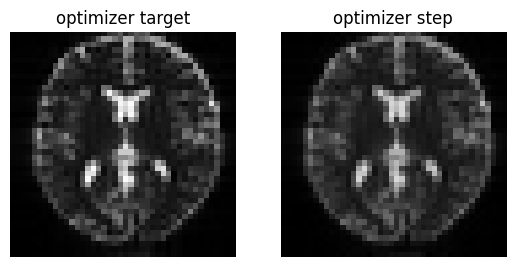

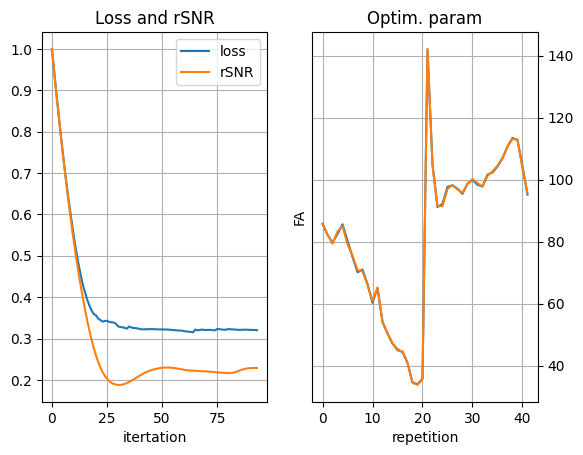

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
95 / 100: loss=0.04801705852150917, rSAR=0.2283717691898346, Ref_FA=[ 85.913826  82.06756   79.35933   83.84354   84.42663   77.93811
  75.93395   71.70837   69.603874  65.925964  61.493305  64.84294
  53.981464  50.506577  47.557896  44.446423  45.039513  40.957172
  34.395584  33.649055  35.633633 142.35284  103.84673   91.840706
  90.74874   96.07973   98.44802   96.439964  96.135     98.4572
 100.20524   99.35992   97.93268  100.67758  103.0388   104.595856
 107.090645 110.35334  112.7884   112.71755  103.18648   96.16583 ]


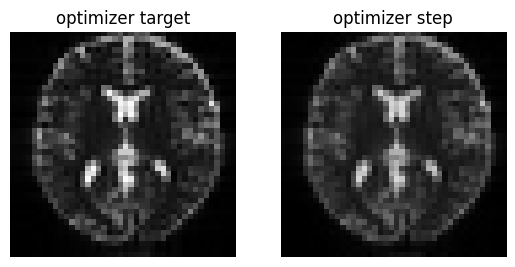

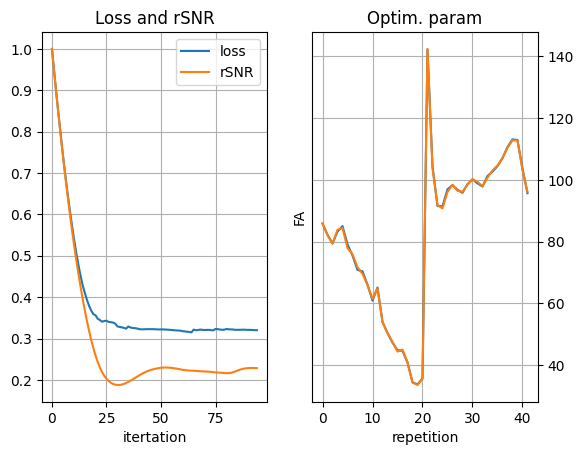

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
96 / 100: loss=0.04865679889917374, rSAR=0.22782820463180542, Ref_FA=[ 86.08651   81.73757   79.51192   84.08567   83.89031   76.8662
  76.248695  72.57932   68.6863    65.866936  61.91246   64.21257
  54.03      50.69295   47.82285   43.987064  45.462543  40.991173
  34.302975  33.50647   35.50932  142.33717  103.41422   91.795815
  90.29668   95.27898   98.33305   96.35596   96.22455   98.34469
 100.16725   99.69431   98.00221  100.12262  103.287025 104.7433
 107.097496 109.954636 112.58334  112.1974   103.05346   96.459656]


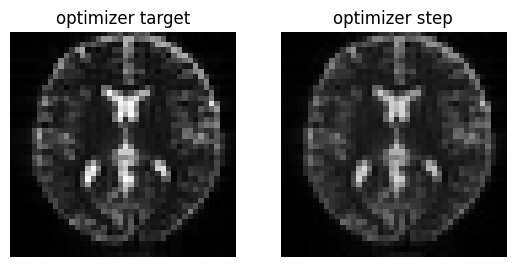

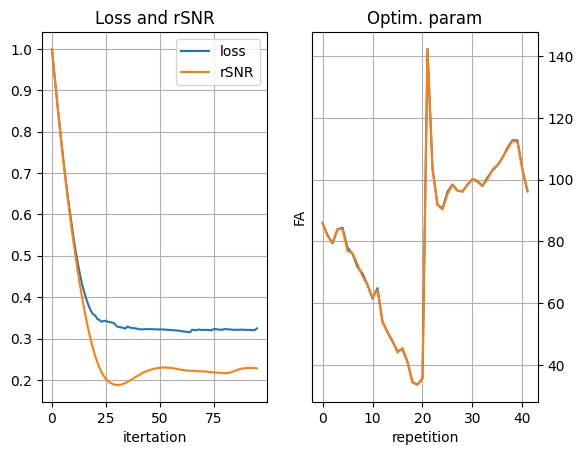

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
97 / 100: loss=0.04854266345500946, rSAR=0.2271534502506256, Ref_FA=[ 86.835175  81.39344   79.92314   83.571335  83.74905   76.20387
  76.343025  73.427635  67.86536   65.881386  62.132942  63.42505
  54.187786  50.999325  48.004154  43.639698  45.783     41.0415
  34.233288  33.394886  35.39394  141.96124  103.57315   90.920135
  90.26377   94.587715  97.82356   96.53643   96.04548   98.20621
 100.19243   99.66382   97.981064  99.74725  103.24154  104.97379
 107.043076 109.387146 112.5634   111.14536  103.837166  95.95997 ]


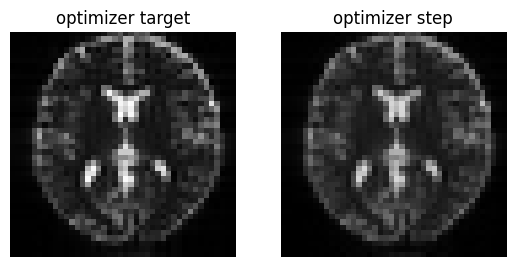

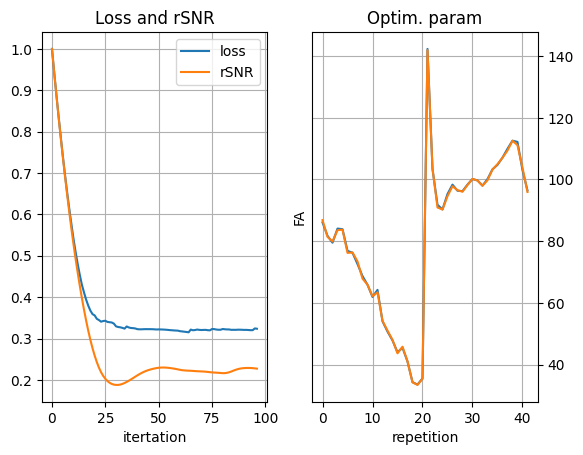

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
98 / 100: loss=0.04853890836238861, rSAR=0.22657664120197296, Ref_FA=[ 87.30186   81.18338   80.42943   82.51838   83.86905   76.01365
  76.21747   74.12117   67.2492    65.954956  62.12932   62.562683
  54.427895  51.398716  48.10851   43.41502   46.008125  41.10516
  34.189907  33.31568   35.286545 141.45918  104.0862    89.72672
  90.366486  94.280396  97.11324   96.9144    95.784096  98.14349
 100.25191   99.611916  97.79411   99.64862  103.02687  105.35204
 106.82835  108.99624  112.558334 109.94159  104.81197   95.6246  ]


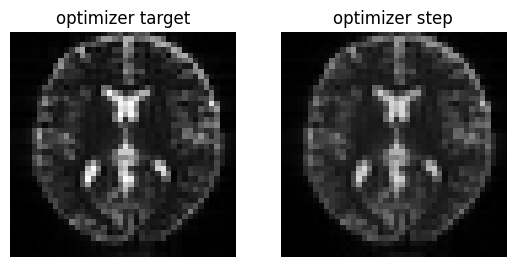

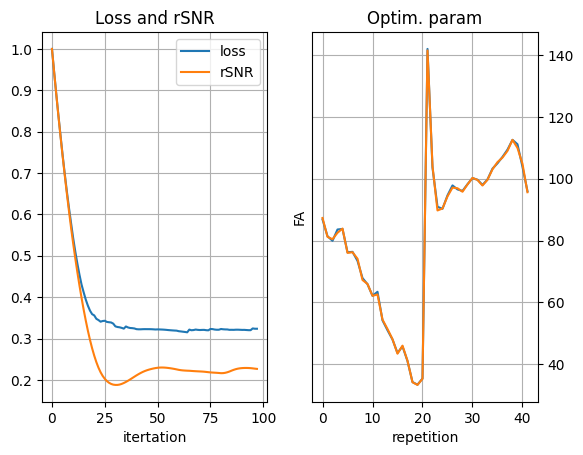

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
99 / 100: loss=0.04855690523982048, rSAR=0.22621497511863708, Ref_FA=[ 87.12721   81.22421   80.8472    81.24854   84.082245  76.28633
  75.924614  74.5528    66.90832   66.06301   61.897182  61.700912
  54.719364  51.85675   48.14548   43.312847  46.14589   41.17891
  34.173553  33.269672  35.18557  141.15298  104.60902   88.67123
  90.38955   94.298744  96.50609   97.27485   95.61073   98.191284
 100.31763   99.68159   97.483246  99.7676   102.82711  105.76729
 106.53031  108.92228  112.38379  108.95057  105.459526  95.90617 ]


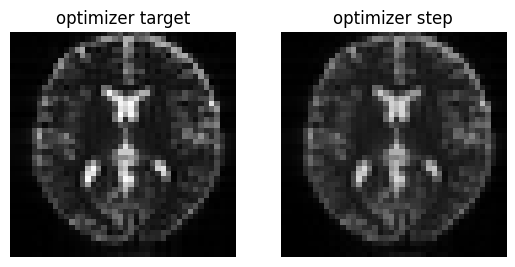

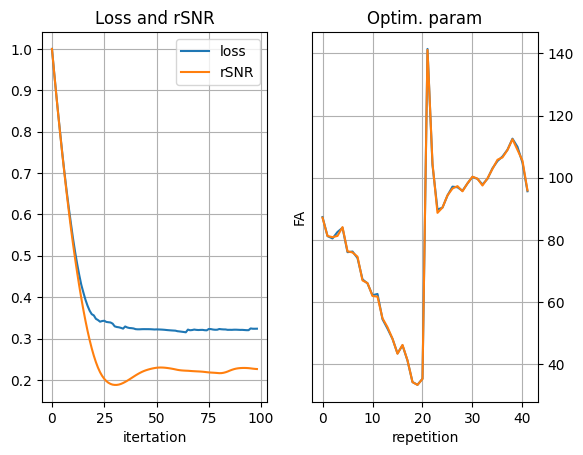

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
100 / 100: loss=0.04855651408433914, rSAR=0.22599869966506958, Ref_FA=[ 86.74121   81.52119   81.02589   80.09136   84.26858   76.93711
  75.55047   74.67368   66.858505  66.17574   61.453815  60.90299
  55.02494   52.342148  48.11878   43.321335  46.20288   41.2591
  34.180233  33.25709   35.08885  141.38948  104.71557   88.06656
  90.16181   94.30546   96.28681   97.28871   95.61095   98.26616
 100.37244   99.72727   97.16621   99.92756  102.78752  105.930115
 106.39627  109.07445  111.71392  108.62619  105.52109   96.50868 ]


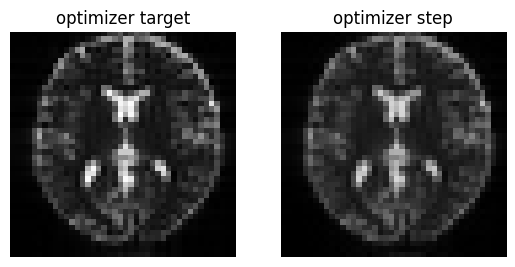

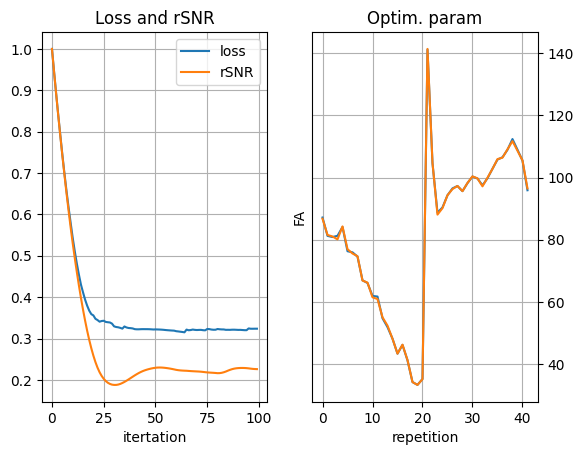

In [ ]:
# @title Perform optimization

# sequence parametes
base_resolution=42
Ex_FA = 90    # excitation flip angle
Ref_FA = torch.full((base_resolution,), 180.0, requires_grad=True)  # refocusing flip angles

# initalize optimizer
iterations = 100
params = [{"params": Ref_FA, "lr": 5.0}]  # adjust learning rate as needed
optimizer = torch.optim.Adam(params)

lambda_SAR = 0.15
lambda_image = 1-lambda_SAR

loss_hist = []
rSNR_hist = []
Ref_FA_hist = []

# optimization loop
for i in range(iterations):

    optimizer.zero_grad()

    # ====
    # simulate
    # ====

    with pulseqzero.mr0_mode():
      seq, encoding = tse_sequence(base_resolution=base_resolution, Ex_FA=Ex_FA, Ref_FA=Ref_FA)

      seq0 = seq.to_mr0()

      if i%5 == 0:
        graph = mr0.compute_graph(seq0, obj_p.build(), 100000, 1e-4)

      signal = mr0.execute_graph(graph, seq0, obj_p.build(), 1e-4, 1e-4)
    # reconstruct image
    space = reconstruction(signal, encoding, base_resolution, base_resolution)
    image = torch.abs(space) # current optimizer step image


    # ====
    # loss computation
    # ====

    MSE_image = ((image - target)**2).mean()/((target**2).mean())  # MSE of images
    rSAR = torch.sum(Ref_FA**2)/torch.sum(Ref_FA_target**2)     # relative SAR

    loss = lambda_SAR * rSAR + lambda_image * MSE_image

    print(f"{i+1} / {iterations}: loss={loss.item()}, rSAR={rSAR}, Ref_FA={Ref_FA.detach().numpy()}")

    loss_hist.append(loss.item())
    rSNR_hist.append(rSAR.item())
    Ref_FA_hist.append(Ref_FA.detach().numpy().copy())

    # ====
    # perform optimizer step
    # ====

    loss.backward()
    optimizer.step()

    # plot images
    plot_results_images(target, image)

    # optimization timeline
    plot_optimizer_history(loss_hist, Ref_FA_hist, rSNR_hist)

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
Optimized rSNR: 0.22221577167510986
Optimized Ref_FA: [ 85.39331   77.50994   77.194176  80.33685   86.64225   78.2611
  75.900345  73.01485   67.76266   65.66772   59.40401   61.299614
  57.48086   52.867832  48.62549   48.644028  45.872375  43.259705
  35.172115  34.795853  33.039528 141.46912  100.351875  91.813286
  90.63515  100.218216 100.61784   94.996666  95.80733   94.95462
  99.22951   97.66548   95.273224  98.570114 101.75522  103.065994
 104.568115 104.64058  104.70619  106.12766  102.74228   97.37626 ]


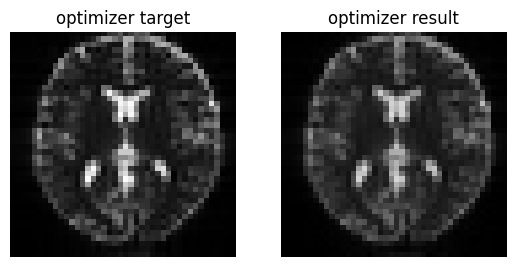

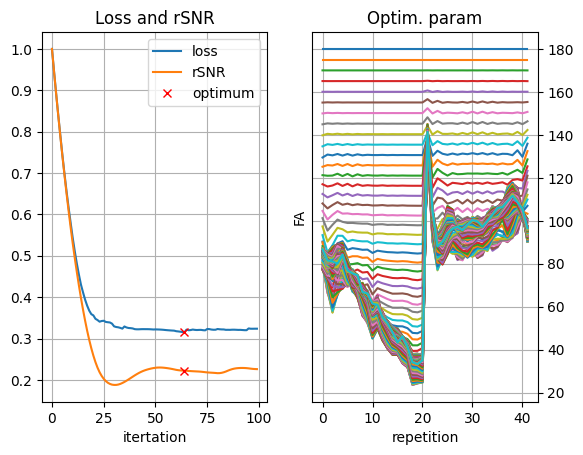

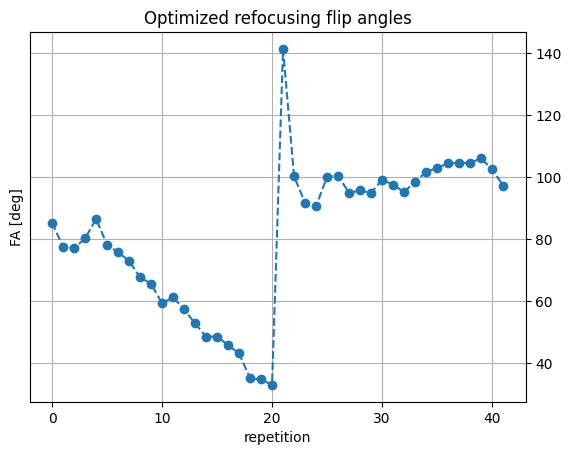

In [ ]:
# @title Evaluate optimization result

# simute optimizer result: optimal flip angle configuration
with pulseqzero.mr0_mode():
  seq, encoding = tse_sequence(base_resolution=base_resolution, Ex_FA=Ex_FA, Ref_FA=Ref_FA_hist[np.argmin(loss_hist)])
  seq0 = seq.to_mr0()
  graph = mr0.compute_graph(seq0, obj_p.build(), 100000, 1e-8)
  signal = mr0.execute_graph(graph, seq0, obj_p.build(), 1e-8, 1e-8)  # high accuracy to check if more states are neccesary

  # reconstruct image
  space = reconstruction(signal, encoding, base_resolution, base_resolution)
  result = torch.abs(space) # current optiumizer step image

# ====
# plot results
# ====

print(f"Optimized rSNR: {rSNR_hist[np.argmin(loss_hist)]}")
print(f"Optimized Ref_FA: {Ref_FA_hist[np.argmin(loss_hist)]}")

# images
plot_results_images(target, result, finished=True)

# optimization timeline
plot_optimizer_history(loss_hist, Ref_FA_hist, rSNR_hist, finished=True)

# optimized flip angle configuration
plot_optimized_flipangles(Ref_FA_hist[np.argmin(loss_hist)])